# Intro to 2D CNNs
A description and demo notebook to go through creating a 2D CNN and using it with dummy data

## 0. Setting up dummy data

Before learning how to use the cores, let's create a dummy data images. This data will be similar to a batch of images.

Throughout the notebook we will refer to the elements of this shape in the following manner:

[1] is the number of channels (can be input, hidden, output)

[144] is the height of image or feature maps

[256] is the height of image or feature maps

[32] is the batch size, which is not as relevant for understanding the material in this notebook.

In [1]:
# To access to neuropixel_predictor
import sys
import os
sys.path.append('../')

# Basic imports
import warnings
import random

# Essential imports
import numpy as np
import torch

In [2]:
warnings.filterwarnings("ignore", category=UserWarning)
device = "cuda" if torch.cuda.is_available() else "cpu"
random_seed = 42

## 1. Setting Up the data

In [3]:
IMAGE_WIDTH = 36
IMAGE_HEIGHT = 22

images = torch.ones(32, 1, IMAGE_WIDTH, IMAGE_HEIGHT)


## 2. Using Stacked 2D Core

In [4]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 7,
    'hidden_kern': 5,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    'gamma_input': 6.3831
}

In [5]:
# from neuralpredictors.layers.cores import Stacked2dCore
# from neuralpredictors.utils import get_module_output

# core = Stacked2dCore(input_channels=1,
#                      hidden_channels=64,
#                      input_kern=9,
#                      hidden_kern=7)

# in_shape_dict = {k: get_module_output(core, in_shape)[1:] for k, in_shape in in_shapes_dict.items()}



from neuropixel_predictor.layers.cores import Stacked2dCore 

stacked2d_core = Stacked2dCore(**stacked2dcore_config)
stacked2d_core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 6.3831|skip = 0]

In [6]:
# Trying out on images
stacked2dcore_out = stacked2d_core(images)
print(stacked2dcore_out.shape)

torch.Size([32, 64, 36, 22])


## 3. Using Readout to attach Factorized Readout

In [7]:
from neuropixel_predictor.layers.readouts import FullFactorized2d, MultiReadoutBase

In [8]:
in_shapes_dict = {
    '2023-03-15_11-05-00': torch.Size([64, IMAGE_WIDTH, IMAGE_HEIGHT]),
    # '2023-03-15_15-23': torch.Size([64, 150, 200])
}

n_neurons_dict = {
    '2023-03-15_11-05-00': 453,
    # '2023-03-15_15-23': 200
}

In [9]:
factorized_readout = MultiReadoutBase(
    in_shape_dict=in_shapes_dict,
    n_neurons_dict=n_neurons_dict,
    base_readout=FullFactorized2d,
    bias=True,
)

## 4. Invoke core and readout (dummy data)

In [10]:
# Forward pass with core
core_output = stacked2d_core(images)

# Forward pass with readout
readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")

readout_output_sample

tensor([[ 0.0073, -0.0065,  0.0058,  ...,  0.0012, -0.0029, -0.0028],
        [ 0.0073, -0.0065,  0.0058,  ...,  0.0012, -0.0029, -0.0028],
        [ 0.0073, -0.0065,  0.0058,  ...,  0.0012, -0.0029, -0.0028],
        ...,
        [ 0.0073, -0.0065,  0.0058,  ...,  0.0012, -0.0029, -0.0028],
        [ 0.0073, -0.0065,  0.0058,  ...,  0.0012, -0.0029, -0.0028],
        [ 0.0073, -0.0065,  0.0058,  ...,  0.0012, -0.0029, -0.0028]],
       grad_fn=<AddBackward0>)

## 5. Testing with test data (from sinzlab)
Utility functions from https://github.com/sinzlab/sensorium

In [11]:
# %%capture 
# !pip install git+https://github.com/sinzlab/sensorium.git

**Defining some helper functions to extract the data**

In [12]:
# # The following are minimal adaptations of three utility functions found in nnfabrik that we need to initialise
# # the core and readouts later on.

# def get_data(dataset_fn, dataset_config):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/builder.py#L87
#     for the original implementation and documentation if you are interested.
#     """
#     return dataset_fn(**dataset_config)

# def get_dims_for_loader_dict(dataloaders):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L39
#     for the original implementation and docstring if you are interested.
#     """
    
#     def get_io_dims(data_loader):
#         items = next(iter(data_loader))
#         if hasattr(items, "_asdict"):  # if it's a named tuple
#             items = items._asdict()

#         if hasattr(items, "items"):  # if dict like
#             return {k: v.shape for k, v in items.items()}
#         else:
#             return (v.shape for v in items)

#     return {k: get_io_dims(v) for k, v in dataloaders.items()}


# def set_random_seed(seed: int, deterministic: bool = True):
#     """
#     See https://github.com/sinzlab/nnfabrik/blob/5b6e7379cb5724a787cdd482ee987b8bc0dfacf3/nnfabrik/utility/nn_helpers.py#L53
#     for the original implementation and docstring if you are intereseted.
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     if deterministic:
#         torch.backends.cudnn.benchmark = False
#         torch.backends.cudnn.deterministic = True
#     torch.manual_seed(seed)  # this sets both CPU and CUDA seeds for PyTorch

**Loading the data**

In [13]:
# ## Load the data: you can modify this if you have stored it in another location
# from sensorium.datasets import static_loaders

# DATA_PATH = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Test/'

# filenames = [
#     DATA_PATH + 'static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip', 
#     DATA_PATH + 'static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip'
#     ]

# dataset_config = {'paths': filenames,
#                  'normalize': True,
#                  'include_behavior': False,
#                  'include_eye_position': True,
#                  'batch_size': 32,
#                  'scale':1,
#                  'cuda': True if device == 'cuda' else False,
#                  }

# dataloaders = get_data(dataset_fn=static_loaders, dataset_config=dataset_config)

In [14]:
# datapoint = list(dataloaders['train']['21067-10-18'])[0]
# images = datapoint[0]
# responses = datapoint[1]
# images.shape, responses.shape

**Process the data step by step**

In [15]:
# # We only need the train dataloaders to extract the session keys (could also use test or validation for this)
# train_dataloaders = dataloaders["train"]

# # Obtain the named tuple fields from the first entry of the first dataloader in the dictionary
# example_batch = next(iter(list(train_dataloaders.values())[0]))
# in_name, out_name = (
#     list(example_batch.keys())[:2] if isinstance(example_batch, dict) else example_batch._fields[:2]
# )

# session_shape_dict = get_dims_for_loader_dict(train_dataloaders)
# input_channels = [v[in_name][1] for v in session_shape_dict.values()]

# core_input_channels = (
#     list(input_channels.values())[0]
#     if isinstance(input_channels, dict)
#     else input_channels[0]
# )

**Core: Define Config Params**

In [16]:
# stacked2dcore_config = {
#     # core args
#     'input_kern': 7,
#     'hidden_kern': 5,
#     'hidden_channels': 64,
#     'layers': 3,
#     'stack': -1,
#     'pad_input': True,
#     'gamma_input': 6.3831
# }

**Core: Setting up**

In [17]:
# set_random_seed(random_seed)
# core = Stacked2dCore(
#     input_channels=core_input_channels,
#     **stacked2dcore_config,
# )
# core

**Core: Example forward pass**

In [18]:
# print(f"Sample batch shape: {example_batch.images.shape} (batch size, in_channels, in_height, in_width)")

# with torch.no_grad():
#     core_output = core(example_batch.images)
    
# print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


**Readout: Test the factorized**

In [19]:
# with torch.no_grad():
#     readout_output_sample = factorized_readout(core_output, data_key="21067-10-18")


# print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

--------------
--------------
--------------
## 6. Testing with our data

In [20]:
from torch.utils.data import DataLoader

TRAINING_DATA_DIR = '/Users/tarek/Documents/UNI/Lab Rotations/Kremkow/Data/Training'

# 1. Load the images and responses
training_images = np.load(os.path.join(TRAINING_DATA_DIR, 'training_images_2023-03-15_11-05.npy'))
training_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'training_responses_2023-03-15_11-05.npy'))

test_images = np.load(os.path.join(TRAINING_DATA_DIR, 'test_images_2023-03-15_11-05.npy'))
test_responses = np.load(os.path.join(TRAINING_DATA_DIR, 'test_responses_2023-03-15_11-05.npy'))

training_images = training_images.reshape(training_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)
test_images = test_images.reshape(test_images.shape[0], 1, IMAGE_WIDTH, IMAGE_HEIGHT)

# 2. Convert to tensors and typecast to float
training_images = torch.from_numpy(training_images).float()
test_images = torch.from_numpy(test_images).float()

training_responses = torch.from_numpy(training_responses).float()
test_responses = torch.from_numpy(test_responses).float()

# 3. Zip training and test
training_data = list(zip(training_images, training_responses))
test_data = list(zip(test_images, test_responses))
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False)

# 4. Load sample batch
images_batch, responses_batch = next(iter(train_dataloader))

# 5. Validate shape and types
training_images.shape, test_images.shape, images_batch.shape, responses_batch.shape, images_batch.type()

(torch.Size([8388, 1, 36, 22]),
 torch.Size([931, 1, 36, 22]),
 torch.Size([16, 1, 36, 22]),
 torch.Size([16, 453]),
 'torch.FloatTensor')

**Core: Define Config Params**

In [21]:
stacked2dcore_config = {
    # core args
    'input_channels': 1,
    'input_kern': 5,
    'hidden_kern': 3,
    'hidden_channels': 64,
    'layers': 3,
    'stack': -1,
    'pad_input': True,
    # 'gamma_input': 6.3831
}

**Core: Setting up**

In [22]:
core = Stacked2dCore(
    **stacked2dcore_config,
)
core

Stacked2dCore(
  (_input_weights_regularizer): LaplaceL2(
    (laplace): Laplace()
  )
  (features): Sequential(
    (layer0): Sequential(
      (conv): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer1): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
    (layer2): Sequential(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (nonlin): AdaptiveELU()
    )
  )
) [Stacked2dCore regularizers: gamma_hidden = 0|gamma_input = 0.0|skip = 0]

**Core: Example forward pass**

In [23]:
print(f"Sample batch shape: {images_batch.shape} (batch size, in_channels, in_height, in_width)")

with torch.no_grad():
    core_output = core(images_batch)
    
print(f"Core output shape: {core_output.shape} (batch_size, out_channels, out_height, out_width)")


Sample batch shape: torch.Size([16, 1, 36, 22]) (batch size, in_channels, in_height, in_width)
Core output shape: torch.Size([16, 64, 36, 22]) (batch_size, out_channels, out_height, out_width)


**Readout: Test the factorized**

In [24]:
with torch.no_grad():
    readout_output_sample = factorized_readout(core_output, data_key="2023-03-15_11-05-00")


print(f"Readout output shape: {readout_output_sample.shape} (batch_size, n_neurons)")

Readout output shape: torch.Size([16, 453]) (batch_size, n_neurons)


-------------
## 7. Training the model
Adopted similar usage from https://github.com/sinzlab/nnsysident/blob/master/notebooks/tutorial_mouse_models.ipynb

In [25]:
from neuropixel_predictor.training.trainers import simplified_trainer
from neuropixel_predictor.layers.encoders import GeneralizedEncoderBase
import torch.nn as nn

poisson_loss = nn.PoissonNLLLoss(log_input=False, full=True)
mse_loss = nn.MSELoss()
device = 'mps'

# trainer_config_base = {"track_training": True,
#                        "device": device,
#                        "detach_core": False}

In [26]:
model = GeneralizedEncoderBase(
    core,
    factorized_readout,
    elu=True
)

In [27]:
trained_model, training_history = simplified_trainer(
    model=model,
    train_loader=train_dataloader,
    val_loader=test_dataloader,
    loss_fn=poisson_loss,
    device=device,
    max_epochs=50,
    patience=10 # For the early stopping
)

Epoch 1/50 (Train):   0%|                                                                                | 0/525 [00:00<?, ?it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9739696979522705 0.0 219.41488647460938
predictions mean/min/max: 0.9999868869781494 0.9619472622871399 1.0397388935089111
-----
loss:  tensor(6.9602, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):   0%|▏                                                                       | 1/525 [00:00<02:18,  3.77it/s]

PoissonNLLLoss()
responses mean/min/max: 2.944601058959961 0.0 89.9400405883789
predictions mean/min/max: 1.0520519018173218 0.16841155290603638 3.228729009628296
-----
loss:  tensor(7.0578, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.007748603820801 0.0 89.82035827636719
predictions mean/min/max: 1.2340670824050903 0.010945141315460205 6.560435771942139
-----
loss:  tensor(4.7739, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3354451656341553 0.0 139.81358337402344
predictions mean/min/max: 1.3037902116775513 0.02272862195968628 6.6376519203186035
-----
loss:  tensor(5.5540, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1638295650482178 0.0 109.92671203613281
predictions mean/min/max: 1.460113763809204 5.173683166503906e-05 9.539899826049805
-----
loss:  tensor(7.7016, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):   1%|▊                                                                       | 6/525 [00:00<00:26, 19.87it/s]

PoissonNLLLoss()
responses mean/min/max: 3.1595003604888916 0.0 89.9400405883789
predictions mean/min/max: 1.5151642560958862 0.0002785325050354004 14.044154167175293
-----
loss:  tensor(7.0224, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.343909502029419 0.0 159.89340209960938
predictions mean/min/max: 1.6664259433746338 0.00022852420806884766 12.114814758300781
-----
loss:  tensor(7.2807, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.1088342666625977 0.0 89.91008758544922
predictions mean/min/max: 1.7228262424468994 0.00034183263778686523 9.339585304260254
-----
loss:  tensor(4.6400, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9041686058044434 0.0 139.5812530517578
predictions mean/min/max: 1.6573518514633179 9.999999974752427e-07 19.859350204467773
-----
loss:  tensor(8.9704, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.816639423

Epoch 1/50 (Train):   2%|█▌                                                                     | 12/525 [00:00<00:16, 31.65it/s]

predictions mean/min/max: 1.9352192878723145 4.5418739318847656e-05 12.766885757446289
-----
loss:  tensor(7.6687, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5097262859344482 0.0 119.76048278808594
predictions mean/min/max: 2.008211612701416 3.24249267578125e-05 11.496066093444824
-----
loss:  tensor(6.4987, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7494800090789795 0.0 99.83361053466797
predictions mean/min/max: 2.129992961883545 9.999999974752427e-07 14.821158409118652
-----
loss:  tensor(5.2877, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.418259859085083 0.0 169.60426330566406
predictions mean/min/max: 2.197727680206299 1.150369644165039e-05 15.9923734664917
-----
loss:  tensor(6.3596, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.220965623855591 0.0 99.56853485107422
predictions mean/min/max: 2.3222827911376953 9.9999999747

Epoch 1/50 (Train):   3%|██▎                                                                    | 17/525 [00:00<00:13, 37.16it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9574809074401855 0.0 120.1201171875
predictions mean/min/max: 2.4464480876922607 9.999999974752427e-07 15.384611129760742
-----
loss:  tensor(5.4925, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0246291160583496 0.0 139.81358337402344
predictions mean/min/max: 2.543482780456543 9.999999974752427e-07 19.07136344909668
-----
loss:  tensor(5.5064, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.711289644241333 0.0 149.7504119873047
predictions mean/min/max: 2.6276490688323975 9.999999974752427e-07 16.77353858947754
-----
loss:  tensor(5.1538, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9228768348693848 0.0 119.8402099609375
predictions mean/min/max: 2.5192673206329346 9.999999974752427e-07 31.621150970458984
-----
loss:  tensor(6.0240, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.268200874328613

Epoch 1/50 (Train):   4%|███                                                                    | 23/525 [00:00<00:11, 42.10it/s]

PoissonNLLLoss()
responses mean/min/max: 3.180232524871826 0.0 120.1201171875
predictions mean/min/max: 2.8120203018188477 9.999999974752427e-07 19.334108352661133
-----
loss:  tensor(5.0578, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3138484954833984 0.0 139.86013793945312
predictions mean/min/max: 2.8178911209106445 9.999999974752427e-07 30.473527908325195
-----
loss:  tensor(5.9016, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6242098808288574 0.0 199.60079956054688
predictions mean/min/max: 2.937084436416626 1.7881393432617188e-06 23.324024200439453
-----
loss:  tensor(6.2968, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.296851396560669 0.0 120.0400161743164
predictions mean/min/max: 3.0094385147094727 5.245208740234375e-06 24.49726676940918
-----
loss:  tensor(5.8270, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2412071228027

Epoch 1/50 (Train):   6%|███▉                                                                   | 29/525 [00:00<00:11, 45.00it/s]

PoissonNLLLoss()
responses mean/min/max: 4.063704490661621 0.0 159.62753295898438
predictions mean/min/max: 3.097991466522217 9.999999974752427e-07 29.154232025146484
-----
loss:  tensor(6.8531, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.336756706237793 0.0 110.110107421875
predictions mean/min/max: 3.1324331760406494 9.999999974752427e-07 28.64879608154297
-----
loss:  tensor(5.4193, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5207865238189697 0.0 149.70059204101562
predictions mean/min/max: 3.141843318939209 9.999999974752427e-07 24.088470458984375
-----
loss:  tensor(6.0249, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5032174587249756 0.0 149.7504119873047
predictions mean/min/max: 3.2465546131134033 2.3245811462402344e-06 24.648263931274414
-----
loss:  tensor(5.0478, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.727558374404

Epoch 1/50 (Train):   7%|████▋                                                                  | 35/525 [00:00<00:10, 47.57it/s]

PoissonNLLLoss()
responses mean/min/max: 2.644589900970459 0.0 99.83361053466797
predictions mean/min/max: 3.3212194442749023 9.999999974752427e-07 30.8914737701416
-----
loss:  tensor(5.1969, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.383871555328369 0.0 149.8501434326172
predictions mean/min/max: 3.3195338249206543 9.999999974752427e-07 25.17070960998535
-----
loss:  tensor(5.6174, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4881927967071533 0.0 140.0
predictions mean/min/max: 3.28769850730896 9.999999974752427e-07 25.315410614013672
-----
loss:  tensor(4.5565, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.763470411300659 0.0 149.45201110839844
predictions mean/min/max: 3.282209873199463 9.999999974752427e-07 25.484905242919922
-----
loss:  

Epoch 1/50 (Train):   8%|█████▍                                                                 | 40/525 [00:01<00:10, 47.71it/s]

tensor(6.1539, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.131312608718872 0.0 199.40179443359375
predictions mean/min/max: 3.190463066101074 9.999999974752427e-07 32.625518798828125
-----
loss:  tensor(5.5143, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9061272144317627 0.0 89.88015747070312
predictions mean/min/max: 3.2463600635528564 9.999999974752427e-07 36.97158432006836
-----
loss:  tensor(4.9426, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.53216290473938 0.0 119.80033111572266
predictions mean/min/max: 3.183514356613159 9.999999974752427e-07 26.4622859954834
-----
loss:  tensor(5.5678, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9816930294036865 0.0 120.0400161743164
predictions mean/min/max: 3.1440839767456055 9.999999974752427e-07 32.869171142578125
-----
loss:  tensor(5.0600, device='mps:0', grad_fn=<MeanBackward0>)
Po

Epoch 1/50 (Train):   9%|██████▏                                                                | 46/525 [00:01<00:09, 49.40it/s]

responses mean/min/max: 3.0382728576660156 0.0 209.86009216308594
predictions mean/min/max: 3.1752309799194336 9.999999974752427e-07 27.723678588867188
-----
loss:  tensor(5.2727, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7020113468170166 0.0 99.73403930664062
predictions mean/min/max: 3.2148942947387695 9.999999974752427e-07 32.75825119018555
-----
loss:  tensor(4.7331, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8499245643615723 0.0 129.87013244628906
predictions mean/min/max: 3.2289209365844727 9.999999974752427e-07 44.044471740722656
-----
loss:  tensor(5.7408, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5142250061035156 0.0 140.2337188720703
predictions mean/min/max: 3.2507636547088623 9.999999974752427e-07 33.66807174682617
-----
loss:  tensor(4.6941, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  10%|███████                                                                | 52/525 [00:01<00:09, 48.36it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8249855041503906 0.0 179.8800811767578
predictions mean/min/max: 3.254349708557129 9.999999974752427e-07 31.188955307006836
-----
loss:  tensor(4.8953, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.606348991394043 0.0 99.7672119140625
predictions mean/min/max: 3.2356619834899902 9.999999974752427e-07 32.11847686767578
-----
loss:  tensor(4.5640, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.87309193611145 0.0 90.0
predictions mean/min/max: 3.2145657539367676 9.999999974752427e-07 38.742488861083984
-----
loss:  tensor(4.8736, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6067137718200684 0.0 110.14686584472656
predictions mean/min/max: 3.187607765197754 9.999999974752427e-07 35.02606201171875
-----
loss:  tensor(4.4459, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2298617362976074 0.0 109.9633

Epoch 1/50 (Train):  11%|███████▋                                                               | 57/525 [00:01<00:09, 48.07it/s]

PoissonNLLLoss()
responses mean/min/max: 2.999009370803833 0.0 129.87013244628906
predictions mean/min/max: 3.021958827972412 9.999999974752427e-07 36.893402099609375
-----
loss:  tensor(4.7659, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.655745506286621 0.0 119.88011932373047
predictions mean/min/max: 3.0775656700134277 9.999999974752427e-07 28.098711013793945
-----
loss:  tensor(5.5584, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3769407272338867 0.0 199.60079956054688
predictions mean/min/max: 2.967176675796509 9.999999974752427e-07 36.99909210205078
-----
loss:  tensor(5.4631, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.417120933532715 0.0 119.80033111572266
predictions mean/min/max: 3.1254682540893555 3.516674041748047e-06 38.26082229614258
-----
loss:  

Epoch 1/50 (Train):  12%|████████▌                                                              | 63/525 [00:01<00:09, 49.20it/s]

tensor(5.2603, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6002211570739746 0.0 109.89010620117188
predictions mean/min/max: 3.1250076293945312 1.4901161193847656e-06 37.29719543457031
-----
loss:  tensor(4.4030, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7767536640167236 0.0 80.0533676147461
predictions mean/min/max: 3.1205945014953613 1.9073486328125e-06 37.97258758544922
-----
loss:  tensor(4.7907, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.3015456199646 0.0 150.2504119873047
predictions mean/min/max: 3.0977532863616943 9.999999974752427e-07 33.28498458862305
-----
loss:  tensor(6.0671, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6067354679107666 0.0 129.826904296875
predictions mean/min/max: 3.1222739219665527 9.999999974752427e-07 32.56849670410156
-----
loss:  tensor(5.2944, device='mps:0', grad_fn=<MeanBackward0>)
Poiss

Epoch 1/50 (Train):  13%|█████████▎                                                             | 69/525 [00:01<00:09, 50.42it/s]

PoissonNLLLoss()
responses mean/min/max: 4.225196838378906 0.0 189.74700927734375
predictions mean/min/max: 3.3420777320861816 2.0265579223632812e-06 38.76710891723633
-----
loss:  tensor(6.1277, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2841155529022217 0.0 149.7504119873047
predictions mean/min/max: 3.368746757507324 9.999999974752427e-07 33.890968322753906
-----
loss:  tensor(5.2428, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3311898708343506 0.0 149.8501434326172
predictions mean/min/max: 3.4026029109954834 9.999999974752427e-07 37.846500396728516
-----
loss:  tensor(4.7332, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.371873617172241 0.0 109.85353088378906
predictions mean/min/max: 3.4594950675964355 1.0132789611816406e-06 40.8647346496582
-----
loss:  tensor(4.2976, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.89594435691

Epoch 1/50 (Train):  14%|██████████▏                                                            | 75/525 [00:01<00:09, 49.87it/s]

PoissonNLLLoss()
responses mean/min/max: 3.4902820587158203 0.0 149.7504119873047
predictions mean/min/max: 3.5673720836639404 2.9802322387695312e-06 52.69457244873047
-----
loss:  tensor(5.2214, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0542619228363037 0.0 129.826904296875
predictions mean/min/max: 3.485574245452881 1.609325408935547e-05 33.472381591796875
-----
loss:  tensor(4.8645, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2502222061157227 0.0 144.83102416992188
predictions mean/min/max: 3.445333957672119 1.33514404296875e-05 51.512107849121094
-----
loss:  tensor(4.9139, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  15%|██████████▉                                                            | 81/525 [00:01<00:08, 49.95it/s]

PoissonNLLLoss()
responses mean/min/max: 1.9234446287155151 0.0 99.83361053466797
predictions mean/min/max: 3.428523302078247 4.231929779052734e-06 36.29150390625
-----
loss:  tensor(4.0472, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.046682119369507 0.0 199.66722106933594
predictions mean/min/max: 3.3650739192962646 9.999999974752427e-07 47.24843215942383
-----
loss:  tensor(5.0213, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.651304244995117 0.0 119.8402099609375
predictions mean/min/max: 3.2902719974517822 3.3974647521972656e-06 45.09938430786133
-----
loss:  tensor(5.5790, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.249040126800537 0.0 149.45201110839844
predictions mean/min/max: 3.196885585784912 1.150369644165039e-05 32.1520881652832
-----
loss:  tensor(5.3811, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8866217136383057 0.

Epoch 1/50 (Train):  17%|███████████▊                                                           | 87/525 [00:01<00:08, 50.63it/s]

PoissonNLLLoss()
responses mean/min/max: 2.2323663234710693 0.0 119.96001434326172
predictions mean/min/max: 2.962445020675659 0.00015527009963989258 34.13091278076172
-----
loss:  tensor(4.2780, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4866511821746826 0.0 119.56160736083984
predictions mean/min/max: 2.941077470779419 6.520748138427734e-05 35.320072174072266
-----
loss:  tensor(4.8032, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4102046489715576 0.0 129.87013244628906
predictions mean/min/max: 2.9355084896087646 0.00010848045349121094 32.50568771362305
-----
loss:  

Epoch 1/50 (Train):  18%|████████████▌                                                          | 93/525 [00:02<00:08, 50.54it/s]

tensor(5.4897, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.17523193359375 0.0 129.7405242919922
predictions mean/min/max: 2.966693162918091 0.00021719932556152344 33.09889221191406
-----
loss:  tensor(6.3678, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0872995853424072 0.0 129.826904296875
predictions mean/min/max: 3.0009653568267822 0.00014013051986694336 33.21269989013672
-----
loss:  tensor(4.9693, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.633484125137329 0.0 110.07337951660156
predictions mean/min/max: 3.056870222091675 0.00012886524200439453 35.450042724609375
-----
loss:  tensor(4.5286, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7640130519866943 0.0 129.826904296875
predictions mean/min/max: 3.0747156143188477 5.14984130859375e-05 33.69088363647461
-----
loss:  tensor(4.5203, device='mps:0', grad_fn=<MeanBackward0>)
Poi

Epoch 1/50 (Train):  19%|█████████████▍                                                         | 99/525 [00:02<00:08, 49.93it/s]

tensor(4.9159, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.382957696914673 0.0 159.73377990722656
predictions mean/min/max: 3.134263753890991 0.00040918588638305664 32.849395751953125
-----
loss:  tensor(5.5189, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6481311321258545 0.0 100.0
predictions mean/min/max: 3.144040107727051 0.000164031982421875 39.78236770629883
-----
loss:  tensor(4.4531, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8327560424804688 0.0 180.30050659179688
predictions mean/min/max: 3.146111488342285 0.0001099705696105957 41.97446060180664
-----
loss:  tensor(5.7914, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.720057964324951 0.0 89.85025024414062
predictions mean/min/max: 3.1636550426483154 9.083747863769531e-05 38.826438903808594
-----
loss:  tensor(4.5652, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLos

Epoch 1/50 (Train):  20%|██████████████                                                        | 105/525 [00:02<00:08, 48.25it/s]

PoissonNLLLoss()
responses mean/min/max: 3.359370708465576 0.0 119.8402099609375
predictions mean/min/max: 3.169811487197876 5.358457565307617e-05 38.11355972290039
-----
loss:  tensor(5.2069, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7787461280822754 0.0 119.80033111572266
predictions mean/min/max: 3.1891367435455322 7.092952728271484e-06 44.56708908081055
-----
loss:  tensor(4.6307, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6146607398986816 0.0 109.56175231933594
predictions mean/min/max: 3.1938815116882324 0.00015491247177124023 35.220123291015625
-----
loss:  tensor(5.5393, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()


Epoch 1/50 (Train):  21%|██████████████▋                                                       | 110/525 [00:02<00:09, 45.71it/s]

responses mean/min/max: 3.513507843017578 0.0 179.22335815429688
predictions mean/min/max: 3.2038493156433105 5.0067901611328125e-06 43.07246780395508
-----
loss:  tensor(5.1313, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.050408840179443 0.0 110.22044372558594
predictions mean/min/max: 3.2106106281280518 0.0002636909484863281 39.632511138916016
-----
loss:  tensor(6.0584, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0221917629241943 0.0 110.18363952636719
predictions mean/min/max: 3.2218785285949707 0.0007646083831787109 36.914730072021484
-----
loss:  tensor(4.8616, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4589338302612305 0.0 139.67408752441406
predictions mean/min/max: 3.2288029193878174 0.0006769299507141113 34.58952713012695
-----
loss:  tensor(5.3124, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1910219192504883 0.0 119.

Epoch 1/50 (Train):  22%|███████████████▎                                                      | 115/525 [00:02<00:09, 45.42it/s]

PoissonNLLLoss()
responses mean/min/max: 3.14390230178833 0.0 180.12008666992188
predictions mean/min/max: 3.358750581741333 0.00010371208190917969 43.254127502441406
-----
loss:  tensor(4.9071, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1994924545288086 0.0 99.73403930664062
predictions mean/min/max: 3.398101806640625 7.659196853637695e-05 41.9224853515625
-----
loss:  tensor(4.9629, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.373861789703369 0.0 99.83361053466797


Epoch 1/50 (Train):  23%|████████████████▏                                                     | 121/525 [00:02<00:08, 48.14it/s]

predictions mean/min/max: 3.4284167289733887 3.165006637573242e-05 47.05207824707031
-----
loss:  tensor(4.1118, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3486688137054443 0.0 110.29412078857422
predictions mean/min/max: 3.467426061630249 2.086162567138672e-05 44.15507125854492
-----
loss:  tensor(5.3542, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5647528171539307 0.0 129.78369140625
predictions mean/min/max: 3.4747188091278076 2.968311309814453e-05 40.277870178222656
-----
loss:  tensor(4.5597, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4203286170959473 0.0 160.0533447265625
predictions mean/min/max: 3.3504340648651123 3.30805778503418e-05 49.218719482421875
-----
loss:  tensor(5.1635, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0803794860839844 0.0 149.80026245117188
predictions mean/min/max: 3.3021273612976074 0.000133991

Epoch 1/50 (Train):  25%|█████████████████▋                                                    | 133/525 [00:02<00:07, 49.72it/s]

PoissonNLLLoss()
responses mean/min/max: 3.1575872898101807 0.0 119.76048278808594
predictions mean/min/max: 3.2603166103363037 2.8789043426513672e-05 37.92824935913086
-----
loss:  tensor(5.1791, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3504798412323 0.0 120.0400161743164
predictions mean/min/max: 3.156273603439331 7.092952728271484e-06 41.27501678466797
-----
loss:  tensor(4.7258, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.011676073074341 0.0 89.97000885009766
predictions mean/min/max: 3.117526054382324 5.841255187988281e-06 42.696773529052734
-----
loss:  tensor(4.7316, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1485767364501953 0.0 109.85353088378906
predictions mean/min/max: 3.085636854171753 3.635883331298828e-06 44.04886245727539
-----
loss:  tensor(4.9026, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8365817070007324

Epoch 1/50 (Train):  26%|██████████████████▍                                                   | 138/525 [00:03<00:08, 46.87it/s]

PoissonNLLLoss()
responses mean/min/max: 3.5487301349639893 0.0 149.8501434326172
predictions mean/min/max: 3.160921573638916 0.0008484125137329102 39.143184661865234
-----
loss:  tensor(5.1216, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4769034385681152 0.0 180.0
predictions mean/min/max: 3.18738055229187 0.0006628036499023438 42.08412551879883
-----
loss:  tensor(4.2573, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3885722160339355 0.0 129.826904296875
predictions mean/min/max: 3.188281536102295 0.0019690990447998047 35.449440002441406
-----
loss:  tensor(5.0006, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.347028970718384 0.0 129.43910217285156
predictions mean/min/max: 3.199032783508301 0.001967310905456543 35.901554107666016
-----
loss:  tensor(4.9638, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2421927452087402 0.0 89.94004

Epoch 1/50 (Train):  27%|███████████████████▏                                                  | 144/525 [00:03<00:07, 48.59it/s]

tensor(4.8981, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.380251407623291 0.0 190.31719970703125
predictions mean/min/max: 3.209660291671753 0.0037007927894592285 37.364559173583984
-----
loss:  tensor(5.0484, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6928396224975586 0.0 129.91339111328125
predictions mean/min/max: 3.1925859451293945 0.0028102993965148926 39.122798919677734
-----
loss:  tensor(4.5141, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.519651174545288 0.0 149.20423889160156


Epoch 1/50 (Train):  28%|███████████████████▊                                                  | 149/525 [00:03<00:08, 45.19it/s]

predictions mean/min/max: 3.1701254844665527 0.002859652042388916 41.14314270019531
-----
loss:  tensor(5.4761, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.45500111579895 0.0 109.85353088378906
predictions mean/min/max: 3.2052955627441406 0.006220757961273193 37.00025177001953
-----
loss:  tensor(4.4111, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.344259262084961 0.0 90.06004333496094
predictions mean/min/max: 3.1995723247528076 0.0030624866485595703 44.06559371948242
-----
loss:  tensor(4.0486, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.1262903213500977 0.0 100.0333480834961
predictions mean/min/max: 3.1089930534362793 0.004862308502197266 36.1426887512207
-----
loss:  tensor(4.0867, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.390634059906006 0.0 119.8402099609375
predictions mean/min/max: 3.1056082248687744 0.0046969056129455

Epoch 1/50 (Train):  30%|████████████████████▋                                                 | 155/525 [00:03<00:07, 47.38it/s]

PoissonNLLLoss()
responses mean/min/max: 3.2516534328460693 0.0 129.91339111328125
predictions mean/min/max: 3.0613794326782227 0.0013396143913269043 42.25645446777344
-----
loss:  tensor(5.1264, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.923271417617798 0.0 239.0438232421875
predictions mean/min/max: 2.889188766479492 0.0023573637008666992 35.073612213134766
-----
loss:  tensor(5.7872, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  30%|█████████████████████▎                                                | 160/525 [00:03<00:07, 47.93it/s]

PoissonNLLLoss()
responses mean/min/max: 2.913869619369507 0.0 159.68063354492188
predictions mean/min/max: 2.994325637817383 0.0027510523796081543 42.90910339355469
-----
loss:  tensor(4.6220, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.015129804611206 0.0 99.9666748046875
predictions mean/min/max: 2.885321855545044 0.001497507095336914 46.737483978271484
-----
loss:  tensor(4.5441, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4352288246154785 0.0 179.76031494140625
predictions mean/min/max: 2.8923654556274414 0.0017428994178771973 38.12265396118164
-----
loss:  tensor(5.2871, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2314391136169434 0.0 179.70050048828125
predictions mean/min/max: 2.9885854721069336 0.002201557159423828 38.01579284667969
-----
loss:  tensor(4.9697, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.262367010116577 

Epoch 1/50 (Train):  32%|██████████████████████▏                                               | 166/525 [00:03<00:07, 49.68it/s]

PoissonNLLLoss()
responses mean/min/max: 2.689072608947754 0.0 129.78369140625
predictions mean/min/max: 3.2637510299682617 0.0014691948890686035 41.39130401611328
-----
loss:  tensor(4.5230, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0164706707000732 0.0 119.80033111572266
predictions mean/min/max: 3.1772501468658447 0.00032526254653930664 51.13096237182617
-----
loss:  tensor(4.7894, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  33%|██████████████████████▉                                               | 172/525 [00:03<00:06, 51.35it/s]

PoissonNLLLoss()
responses mean/min/max: 3.656578540802002 0.0 140.09339904785156
predictions mean/min/max: 3.265294075012207 0.0004493594169616699 57.31555938720703
-----
loss:  tensor(5.2108, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.889796018600464 0.0 149.35279846191406
predictions mean/min/max: 3.2679617404937744 0.00048828125 57.61664581298828
-----
loss:  tensor(6.0030, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6285171508789062 0.0 159.30966186523438
predictions mean/min/max: 3.303727149963379 0.001056075096130371 35.83299255371094
-----
loss:  tensor(5.5830, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4571640491485596 0.0 149.8501434326172
predictions mean/min/max: 3.3543925285339355 0.0014734268188476562 40.15695571899414
-----
loss:  tensor(5.0065, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.642301559448242 0.0 119

Epoch 1/50 (Train):  34%|███████████████████████▋                                              | 178/525 [00:03<00:07, 49.31it/s]

responses mean/min/max: 2.577937364578247 0.0 129.826904296875
predictions mean/min/max: 3.0800485610961914 0.0011493563652038574 46.30979537963867
-----
loss:  tensor(4.4559, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.043854236602783 0.0 119.88011932373047
predictions mean/min/max: 3.041796922683716 0.0012971758842468262 44.97494125366211
-----
loss:  tensor(4.7792, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.658369541168213 0.0 79.86688995361328
predictions mean/min/max: 2.997298240661621 0.0068236589431762695 34.6320915222168
-----
loss:  tensor(4.4857, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3417694568634033 0.0 110.07337951660156
predictions mean/min/max: 2.9465503692626953 0.004305601119995117 37.14059829711914
-----
loss:  tensor(4.1712, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5377614498138428 0.0 79.893478393554

Epoch 1/50 (Train):  35%|████████████████████████▌                                             | 184/525 [00:03<00:06, 49.57it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6642112731933594 0.0 119.88011932373047
predictions mean/min/max: 2.862039089202881 0.0022872090339660645 39.111698150634766
-----
loss:  tensor(4.1175, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.557859182357788 0.0 110.0
predictions mean/min/max: 2.8102245330810547 0.0051500797271728516 34.46400451660156
-----
loss:  tensor(4.5460, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7343544960021973 0.0 119.96001434326172
predictions mean/min/max: 2.881370782852173 0.0006250143051147461 46.44487380981445
-----
loss:  tensor(5.8742, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5186431407928467 0.0 99.93338012695312
predictions mean/min/max: 2.7586669921875 0.0054441094398498535 33.39794158935547
-----
loss:  tensor(5.2237, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  36%|█████████████████████████▏                                            | 189/525 [00:04<00:07, 47.50it/s]

PoissonNLLLoss()
responses mean/min/max: 3.2630228996276855 0.0 139.72056579589844
predictions mean/min/max: 2.870170831680298 0.0010100603103637695 42.486751556396484
-----
loss:  tensor(5.1436, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.039658546447754 0.0 129.95668029785156
predictions mean/min/max: 2.9636828899383545 0.0009579062461853027 44.9693717956543
-----
loss:  tensor(6.2162, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4358739852905273 0.0 179.70050048828125
predictions mean/min/max: 2.85858416557312 0.0035567879676818848 38.524845123291016
-----
loss:  tensor(4.2436, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.714872121810913 0.0 129.5250701904297
predictions mean/min/max: 2.880375862121582 0.007120668888092041 33.92401885986328
-----
loss:  tensor(4.4752, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7981221675872803

Epoch 1/50 (Train):  37%|██████████████████████████                                            | 195/525 [00:04<00:06, 48.41it/s]

PoissonNLLLoss()
responses mean/min/max: 3.565908908843994 0.0 119.96001434326172
predictions mean/min/max: 2.9940996170043945 0.0024648308753967285 34.191650390625
-----
loss:  tensor(5.2302, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.862340211868286 0.0 139.81358337402344
predictions mean/min/max: 3.026398181915283 0.0017937421798706055 36.30024337768555
-----
loss:  tensor(4.6023, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6660878658294678 0.0 150.05001831054688
predictions mean/min/max: 3.027604341506958 0.002217590808868408 35.73627471923828
-----
loss:  

Epoch 1/50 (Train):  38%|██████████████████████████▊                                           | 201/525 [00:04<00:06, 50.11it/s]

tensor(5.6190, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.902730703353882 0.0 129.91339111328125
predictions mean/min/max: 3.05842661857605 0.0025041699409484863 35.853172302246094
-----
loss:  tensor(4.5863, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.901977777481079 0.0 119.88011932373047
predictions mean/min/max: 3.146986722946167 0.0010341405868530273 37.432044982910156
-----
loss:  tensor(4.8669, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3380062580108643 0.0 169.21035766601562
predictions mean/min/max: 3.3185269832611084 0.00042635202407836914 37.204795837402344
-----
loss:  tensor(5.2527, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6478042602539062 0.0 90.06004333496094
predictions mean/min/max: 3.0705857276916504 0.000982522964477539 35.65182876586914
-----
loss:  tensor(4.4880, device='mps:0', grad_fn=<MeanBackward0>)

Epoch 1/50 (Train):  39%|███████████████████████████▌                                          | 207/525 [00:04<00:06, 48.88it/s]

predictions mean/min/max: 3.117218017578125 0.0012714862823486328 36.43430709838867
-----
loss:  tensor(5.2853, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.2928266525268555 0.0 149.70059204101562
predictions mean/min/max: 3.221169948577881 0.0014119744300842285 45.348087310791016
-----
loss:  tensor(5.8034, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1214795112609863 0.0 139.5812530517578
predictions mean/min/max: 3.183208465576172 0.0013828277587890625 39.94389343261719
-----
loss:  

Epoch 1/50 (Train):  40%|████████████████████████████▎                                         | 212/525 [00:04<00:06, 49.12it/s]

tensor(4.8662, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.450756788253784 0.0 239.44129943847656
predictions mean/min/max: 3.2278356552124023 0.0008670687675476074 41.97605514526367
-----
loss:  tensor(5.5015, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.971151828765869 0.0 129.78369140625
predictions mean/min/max: 3.311232328414917 0.00046187639236450195 43.2094841003418
-----
loss:  tensor(4.7633, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.899635076522827 0.0 119.8402099609375
predictions mean/min/max: 3.3121747970581055 0.0006725192070007324 48.8614616394043
-----
loss:  tensor(4.4672, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.779224157333374 0.0 189.74700927734375
predictions mean/min/max: 3.400520086288452 0.0006178617477416992 40.13766860961914
-----
loss:  tensor(4.8669, device='mps:0', grad_fn=<MeanBackward0>)
Poisson

Epoch 1/50 (Train):  42%|█████████████████████████████                                         | 218/525 [00:04<00:06, 50.08it/s]

PoissonNLLLoss()
responses mean/min/max: 2.478036403656006 0.0 110.110107421875
predictions mean/min/max: 3.0486907958984375 0.001580655574798584 36.240352630615234
-----
loss:  tensor(4.3975, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6457502841949463 0.0 99.90010070800781
predictions mean/min/max: 3.1661391258239746 0.000382840633392334 34.307090759277344
-----
loss:  tensor(4.6678, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.638408899307251 0.0 119.80033111572266
predictions mean/min/max: 3.0071194171905518 0.0010446906089782715 40.333290100097656
-----
loss:  tensor(4.5341, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4636218547821045 0.0 219.70706176757812
predictions mean/min/max: 2.817318916320801 0.0008546113967895508 41.70702362060547
-----
loss:  tensor(5.8250, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.80274724960327

Epoch 1/50 (Train):  43%|█████████████████████████████▊                                        | 224/525 [00:04<00:06, 47.24it/s]

PoissonNLLLoss()
responses mean/min/max: 2.778346061706543 0.0 89.88015747070312
predictions mean/min/max: 2.7109670639038086 0.0024077892303466797 34.12868881225586
-----
loss:  tensor(4.4771, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3184974193573 0.0 139.90672302246094
predictions mean/min/max: 2.6382429599761963 0.0025940537452697754 33.633296966552734
-----
loss:  tensor(4.1704, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7458412647247314 0.0 189.74700927734375
predictions mean/min/max: 2.6281559467315674 0.0020693540573120117 34.30954360961914
-----
loss:  tensor(5.7180, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.913975238800049 0.0 109.81697082519531
predictions mean/min/max: 2.522155523300171 0.003284275531768799 39.00837707519531
-----
loss:  tensor(4.9470, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  44%|██████████████████████████████▋                                       | 230/525 [00:04<00:06, 48.68it/s]

PoissonNLLLoss()
responses mean/min/max: 3.057828426361084 0.0 149.95001220703125
predictions mean/min/max: 2.7483584880828857 0.0007997751235961914 37.628910064697266
-----
loss:  tensor(5.1509, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.758755683898926 0.0 99.93338012695312
predictions mean/min/max: 2.5606026649475098 0.0033968687057495117 32.20647430419922
-----
loss:  tensor(4.6771, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7156388759613037 0.0 100.16694641113281
predictions mean/min/max: 2.5247395038604736 0.004129350185394287 31.206298828125
-----
loss:  tensor(4.5404, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9208645820617676 0.0 179.64071655273438
predictions mean/min/max: 2.5353341102600098 0.005943417549133301 32.79509735107422
-----
loss:  tensor(4.7174, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.979014158248901

Epoch 1/50 (Train):  45%|███████████████████████████████▎                                      | 235/525 [00:05<00:06, 48.09it/s]

PoissonNLLLoss()
responses mean/min/max: 3.156649589538574 0.0 90.12016296386719
predictions mean/min/max: 2.635072708129883 0.005217850208282471 33.172447204589844
-----
loss:  tensor(5.0909, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.271110773086548 0.0 99.80039978027344
predictions mean/min/max: 2.7518625259399414 0.0026740431785583496 37.330284118652344
-----
loss:  tensor(4.7239, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.333852767944336 0.0 109.81697082519531
predictions mean/min/max: 2.7329790592193604 0.004140138626098633 33.160884857177734
-----
loss:  tensor(5.2457, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6949105262756348 0.0 119.76048278808594
predictions mean/min/max: 2.878187417984009 0.0027579665184020996 38.36919021606445
-----
loss:  tensor(5.5881, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  46%|████████████████████████████████▏                                     | 241/525 [00:05<00:05, 48.88it/s]

PoissonNLLLoss()
responses mean/min/max: 3.409144163131714 0.0 129.35324096679688
predictions mean/min/max: 2.900087356567383 0.00666356086730957 32.56315231323242
-----
loss:  tensor(5.2463, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6708338260650635 0.0 169.66067504882812
predictions mean/min/max: 3.006624937057495 0.007260382175445557 34.29672622680664
-----
loss:  tensor(5.5870, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8962903022766113 0.0 170.0
predictions mean/min/max: 3.0946598052978516 0.006035208702087402 34.735599517822266
-----
loss:  tensor(5.9002, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.558654308319092 0.0 89.85025024414062
predictions mean/min/max: 3.1844608783721924 0.004599273204803467 35.26075744628906
-----
loss:  tensor(4.2880, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.469480276107788 0.0 139.8135833

Epoch 1/50 (Train):  47%|████████████████████████████████▊                                     | 246/525 [00:05<00:05, 49.09it/s]

predictions mean/min/max: 3.5170063972473145 0.0026493072509765625 41.0339241027832
-----
loss:  tensor(4.5510, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8542890548706055 0.0 119.8402099609375
predictions mean/min/max: 3.6625959873199463 0.006257951259613037 37.17316436767578
-----
loss:  tensor(4.9121, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9514048099517822 0.0 129.826904296875
predictions mean/min/max: 3.564650297164917 0.00020968914031982422 53.84001159667969
-----
loss:  tensor(4.7337, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  48%|█████████████████████████████████▌                                    | 252/525 [00:05<00:05, 50.05it/s]

PoissonNLLLoss()
responses mean/min/max: 3.412130117416382 0.0 139.81358337402344
predictions mean/min/max: 3.538637161254883 0.0017251372337341309 44.4643669128418
-----
loss:  tensor(4.8289, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0991692543029785 0.0 199.26934814453125
predictions mean/min/max: 3.5410640239715576 0.0010320544242858887 45.668209075927734
-----
loss:  tensor(5.2027, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0008251667022705 0.0 119.80033111572266
predictions mean/min/max: 3.5606229305267334 0.0032811760902404785 40.42002487182617
-----
loss:  tensor(4.8080, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.23612117767334 0.0 119.88011932373047
predictions mean/min/max: 3.5427916049957275 0.0023259520530700684 39.24720764160156
-----
loss:  tensor(5.2243, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6740770339965

Epoch 1/50 (Train):  49%|██████████████████████████████████▍                                   | 258/525 [00:05<00:05, 50.16it/s]

tensor(4.4622, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.050070285797119 0.0 210.3505859375
predictions mean/min/max: 3.28080153465271 0.0019630789756774902 40.4127197265625
-----
loss:  tensor(4.9246, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.2762250900268555 0.0 159.73377990722656
predictions mean/min/max: 3.2726340293884277 0.001428067684173584 40.47444152832031
-----
loss:  tensor(5.7621, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4478533267974854 0.0 89.88015747070312
predictions mean/min/max: 3.257396936416626 0.001955270767211914 41.82078552246094
-----
loss:  tensor(4.3350, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.281430244445801 0.0 179.70050048828125
predictions mean/min/max: 3.286991834640503 0.0006496906280517578 40.87978744506836
-----
loss:  tensor(4.7287, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLL

Epoch 1/50 (Train):  50%|███████████████████████████████████▏                                  | 264/525 [00:05<00:05, 50.43it/s]

PoissonNLLLoss()
responses mean/min/max: 4.318790435791016 0.0 199.26934814453125
predictions mean/min/max: 3.099310874938965 0.0015015602111816406 36.994266510009766
-----
loss:  tensor(6.2112, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.835784912109375 0.0 140.0466766357422
predictions mean/min/max: 3.1294822692871094 0.0013739466667175293 36.4229736328125
-----
loss:  tensor(4.7195, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4457290172576904 0.0 109.92671203613281
predictions mean/min/max: 3.1090261936187744 0.002168715000152588 36.37131118774414
-----
loss:  tensor(4.3409, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6180641651153564 0.0 179.8800811767578
predictions mean/min/max: 3.1189768314361572 0.0007340312004089355 48.84050369262695
-----
loss:  tensor(5.2231, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.429870128631592

Epoch 1/50 (Train):  51%|████████████████████████████████████                                  | 270/525 [00:05<00:04, 51.18it/s]

PoissonNLLLoss()
responses mean/min/max: 3.2125332355499268 0.0 149.8501434326172
predictions mean/min/max: 3.1298422813415527 0.00054931640625 49.364990234375
-----
loss:  tensor(4.7140, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3467793464660645 0.0 99.80039978027344
predictions mean/min/max: 3.1481754779815674 0.001362144947052002 38.77505111694336
-----
loss:  tensor(4.2284, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7741403579711914 0.0 89.9400405883789
predictions mean/min/max: 3.1488096714019775 0.0010737776756286621 38.945030212402344
-----
loss:  tensor(4.8648, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.275649309158325 0.0 125.82384490966797
predictions mean/min/max: 3.272859811782837 4.76837158203125e-06 39.73679733276367
-----
loss:  tensor(5.0142, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.865190267562866 0.0 160

Epoch 1/50 (Train):  53%|████████████████████████████████████▊                                 | 276/525 [00:05<00:05, 48.70it/s]

PoissonNLLLoss()
responses mean/min/max: 2.803900718688965 0.0 119.56160736083984
predictions mean/min/max: 3.0276377201080322 0.0023172497749328613 36.30642318725586
-----
loss:  tensor(4.6256, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0311059951782227 0.0 140.0466766357422
predictions mean/min/max: 3.0415782928466797 0.0012368559837341309 35.9181022644043
-----
loss:  tensor(4.8114, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()


Epoch 1/50 (Train):  54%|█████████████████████████████████████▍                                | 281/525 [00:05<00:05, 48.70it/s]

responses mean/min/max: 3.277482271194458 0.0 119.76048278808594
predictions mean/min/max: 2.9947049617767334 0.0020586252212524414 45.99687576293945
-----
loss:  tensor(4.7049, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.177868604660034 0.0 119.8402099609375
predictions mean/min/max: 3.0409131050109863 0.0013722777366638184 37.18894577026367
-----
loss:  tensor(4.9577, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7264983654022217 0.0 149.8501434326172
predictions mean/min/max: 3.0392141342163086 0.0011349320411682129 39.280513763427734
-----
loss:  tensor(5.6320, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.563647508621216 0.0 119.96001434326172
predictions mean/min/max: 3.1441280841827393 0.0001608729362487793 44.93529510498047
-----
loss:  tensor(5.3593, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8229801654815674 0.0 110.14686

Epoch 1/50 (Train):  55%|██████████████████████████████████████▎                               | 287/525 [00:06<00:04, 50.00it/s]

tensor(4.5929, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9283816814422607 0.0 219.63394165039062
predictions mean/min/max: 3.3044309616088867 0.0002613663673400879 45.55540466308594
-----
loss:  tensor(5.0570, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0239386558532715 0.0 229.46458435058594
predictions mean/min/max: 3.2407991886138916 0.0011979937553405762 53.28697204589844
-----
loss:  tensor(4.6774, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  56%|███████████████████████████████████████                               | 293/525 [00:06<00:04, 51.35it/s]

PoissonNLLLoss()
responses mean/min/max: 3.1449084281921387 0.0 119.8402099609375
predictions mean/min/max: 3.230523109436035 0.000784754753112793 55.00387191772461
-----
loss:  tensor(4.7995, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0678462982177734 0.0 89.91008758544922
predictions mean/min/max: 3.3637475967407227 0.00010716915130615234 53.571685791015625
-----
loss:  tensor(4.6789, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.658970355987549 0.0 139.81358337402344
predictions mean/min/max: 3.337096691131592 0.0008548498153686523 39.178165435791016
-----
loss:  tensor(5.3484, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.030813217163086 0.0 150.10006713867188
predictions mean/min/max: 3.2730014324188232 0.0005120038986206055 36.26958465576172
-----
loss:  tensor(4.7220, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8027617931365

Epoch 1/50 (Train):  57%|███████████████████████████████████████▊                              | 299/525 [00:06<00:04, 51.27it/s]

responses mean/min/max: 2.718505382537842 0.0 99.90010070800781
predictions mean/min/max: 3.3586502075195312 0.0003573298454284668 36.73704528808594
-----
loss:  tensor(4.4109, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6032962799072266 0.0 179.64071655273438
predictions mean/min/max: 3.2771196365356445 0.00035440921783447266 37.279945373535156
-----
loss:  tensor(5.2919, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9189093112945557 0.0 119.80033111572266
predictions mean/min/max: 3.2224228382110596 0.000813901424407959 39.834449768066406
-----
loss:  tensor(4.6308, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  58%|████████████████████████████████████████▋                             | 305/525 [00:06<00:04, 51.71it/s]

PoissonNLLLoss()
responses mean/min/max: 2.958836793899536 0.0 109.89010620117188
predictions mean/min/max: 3.3314428329467773 0.00013250112533569336 41.94303894042969
-----
loss:  tensor(4.5695, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9182205200195312 0.0 139.30348205566406
predictions mean/min/max: 3.2313294410705566 6.80088996887207e-05 46.799957275390625
-----
loss:  tensor(4.9514, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.006568193435669 0.0 119.88011932373047
predictions mean/min/max: 3.1305296421051025 0.00010693073272705078 48.60504150390625
-----
loss:  tensor(4.5382, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.687006711959839 0.0 139.76705932617188
predictions mean/min/max: 3.2085745334625244 2.9861927032470703e-05 57.17919921875
-----
loss:  tensor(5.1073, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.996168851852

Epoch 1/50 (Train):  59%|█████████████████████████████████████████▍                            | 311/525 [00:06<00:04, 51.42it/s]

PoissonNLLLoss()
responses mean/min/max: 2.26261043548584 0.0 139.81358337402344
predictions mean/min/max: 2.9343338012695312 0.00010532140731811523 38.53443145751953
-----
loss:  tensor(4.0521, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.653759002685547 0.0 129.87013244628906
predictions mean/min/max: 2.907789707183838 0.00019633769989013672 37.246334075927734
-----
loss:  tensor(5.5737, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3087193965911865 0.0 129.69737243652344
predictions mean/min/max: 2.9259839057922363 4.1544437408447266e-05 51.09236145019531
-----
loss:  tensor(4.5299, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.187518358230591 0.0 110.22044372558594
predictions mean/min/max: 2.8978195190429688 0.0002646446228027344 45.63893127441406
-----
loss:  tensor(3.9095, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5501816272

Epoch 1/50 (Train):  60%|██████████████████████████████████████████▎                           | 317/525 [00:06<00:03, 52.52it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6100945472717285 0.0 159.68063354492188
predictions mean/min/max: 2.894756555557251 0.0003548264503479004 39.7115478515625
-----
loss:  tensor(4.3202, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.070070505142212 0.0 100.0
predictions mean/min/max: 2.9123377799987793 0.00010180473327636719 34.935359954833984
-----
loss:  tensor(4.6425, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.908151149749756 0.0 99.7672119140625
predictions mean/min/max: 2.9117043018341064 0.00032263994216918945 39.73583221435547
-----
loss:  tensor(4.5248, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.013169050216675 0.0 149.60105895996094
predictions mean/min/max: 2.978355646133423 9.310245513916016e-05 35.688350677490234
-----
loss:  tensor(4.9197, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.409470558166504 0.0 159.78

Epoch 1/50 (Train):  62%|███████████████████████████████████████████                           | 323/525 [00:06<00:03, 51.83it/s]

PoissonNLLLoss()
responses mean/min/max: 3.404592275619507 0.0 139.76705932617188
predictions mean/min/max: 3.0354394912719727 0.0002079606056213379 36.119773864746094
-----
loss:  tensor(5.1382, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9187095165252686 0.0 99.90010070800781
predictions mean/min/max: 3.059782028198242 0.00024706125259399414 35.646392822265625
-----
loss:  tensor(4.8078, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.270228147506714 0.0 129.87013244628906
predictions mean/min/max: 2.935924768447876 0.0018513798713684082 38.94899368286133
-----
loss:  tensor(5.0809, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9291539192199707 0.0 150.05001831054688
predictions mean/min/max: 2.930133581161499 0.002737581729888916 49.52626419067383
-----
loss:  tensor(4.5479, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2117009162902

Epoch 1/50 (Train):  63%|███████████████████████████████████████████▊                          | 329/525 [00:06<00:03, 50.15it/s]

PoissonNLLLoss()
responses mean/min/max: 2.533794403076172 0.0 110.0
predictions mean/min/max: 3.004115343093872 0.002223670482635498 50.27172088623047
-----
loss:  tensor(4.5550, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9588141441345215 0.0 129.826904296875
predictions mean/min/max: 3.0191996097564697 0.009407401084899902 37.17909622192383
-----
loss:  tensor(4.7765, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.293564796447754 0.0 119.80033111572266
predictions mean/min/max: 3.000491142272949 0.007339298725128174 38.972740173339844
-----
loss:  tensor(4.2116, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  64%|████████████████████████████████████████████▋                         | 335/525 [00:06<00:03, 51.29it/s]

PoissonNLLLoss()
responses mean/min/max: 3.5342233180999756 0.0 119.88011932373047
predictions mean/min/max: 3.135483980178833 0.002882063388824463 41.06846618652344
-----
loss:  tensor(5.3848, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.204676866531372 0.0 89.88015747070312
predictions mean/min/max: 3.015322685241699 0.0011597275733947754 47.096153259277344
-----
loss:  tensor(4.7215, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.033081293106079 0.0 109.85353088378906
predictions mean/min/max: 3.0196681022644043 0.004089415073394775 46.01145553588867
-----
loss:  tensor(4.6643, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.975457191467285 0.0 119.8402099609375
predictions mean/min/max: 3.0466668605804443 0.00489497184753418 35.18964767456055
-----
loss:  tensor(4.8696, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5089282989501953 0.

Epoch 1/50 (Train):  65%|█████████████████████████████████████████████▍                        | 341/525 [00:07<00:03, 51.59it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9177865982055664 0.0 129.91339111328125
predictions mean/min/max: 3.2484042644500732 0.002045154571533203 49.47051239013672
-----
loss:  tensor(4.4305, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.911501407623291 0.0 100.0333480834961
predictions mean/min/max: 3.3671627044677734 0.0012938380241394043 35.87080764770508
-----
loss:  tensor(5.5948, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5817699432373047 0.0 139.67408752441406
predictions mean/min/max: 3.4010109901428223 0.00368654727935791 37.98936080932617
-----
loss:  tensor(5.1680, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  66%|██████████████████████████████████████████████▎                       | 347/525 [00:07<00:03, 52.21it/s]

PoissonNLLLoss()
responses mean/min/max: 2.5126657485961914 0.0 99.8668441772461
predictions mean/min/max: 3.4833242893218994 0.0021938681602478027 55.02524185180664
-----
loss:  tensor(4.3479, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.685715675354004 0.0 219.78021240234375
predictions mean/min/max: 3.6674022674560547 0.000976264476776123 44.11344528198242
-----
loss:  tensor(5.4044, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.372009754180908 0.0 90.06004333496094
predictions mean/min/max: 3.564343214035034 0.002318739891052246 58.14833450317383
-----
loss:  tensor(4.0069, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.635864496231079 0.0 159.94668579101562
predictions mean/min/max: 3.5767695903778076 0.002189040184020996 37.17121124267578
-----
loss:  tensor(4.4107, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.103889226913452 0.0

Epoch 1/50 (Train):  67%|███████████████████████████████████████████████                       | 353/525 [00:07<00:03, 51.71it/s]

tensor(5.0404, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4506967067718506 0.0 119.52191162109375
predictions mean/min/max: 3.4020376205444336 0.0003007054328918457 37.70878601074219
-----
loss:  tensor(5.1674, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4830243587493896 0.0 99.8668441772461
predictions mean/min/max: 3.37437105178833 0.0003579854965209961 36.732208251953125
-----
loss:  tensor(4.4765, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.103534460067749 0.0 109.81697082519531
predictions mean/min/max: 3.294788122177124 0.00036722421646118164 68.79740905761719
-----
loss:  

Epoch 1/50 (Train):  68%|███████████████████████████████████████████████▊                      | 359/525 [00:07<00:03, 51.68it/s]

tensor(4.6039, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.418560266494751 0.0 109.85353088378906
predictions mean/min/max: 3.35823130607605 9.119510650634766e-05 42.68476104736328
-----
loss:  tensor(4.1492, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9575610160827637 0.0 99.83361053466797
predictions mean/min/max: 3.2552988529205322 0.0007314085960388184 36.99460983276367
-----
loss:  tensor(4.6467, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8113515377044678 0.0 109.85353088378906
predictions mean/min/max: 3.1210474967956543 0.0005933642387390137 43.67052459716797
-----
loss:  tensor(4.5400, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5258023738861084 0.0 139.8042755126953
predictions mean/min/max: 2.936026096343994 0.0005608797073364258 57.927703857421875
-----
loss:  tensor(5.0840, device='mps:0', grad_fn=<MeanBackward0>)
P

Epoch 1/50 (Train):  70%|████████████████████████████████████████████████▋                     | 365/525 [00:07<00:03, 52.45it/s]

responses mean/min/max: 3.1183087825775146 0.0 99.93338012695312
predictions mean/min/max: 2.693315267562866 0.002091705799102783 33.018226623535156
-----
loss:  tensor(5.0819, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.076961994171143 0.0 139.76705932617188
predictions mean/min/max: 2.724036693572998 0.0021591782569885254 32.832275390625
-----
loss:  tensor(5.7754, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.231917858123779 0.0 179.8800811767578
predictions mean/min/max: 2.7417266368865967 0.0035315752029418945 33.299983978271484
-----
loss:  tensor(5.9217, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2801220417022705 0.0 129.78369140625
predictions mean/min/max: 2.748065710067749 0.0028960108757019043 33.98198318481445
-----
loss:  tensor(4.9766, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0445923805236816 0.0 209.650588989257

Epoch 1/50 (Train):  71%|█████████████████████████████████████████████████▍                    | 371/525 [00:07<00:02, 51.99it/s]

PoissonNLLLoss()
responses mean/min/max: 3.161862850189209 0.0 119.88011932373047
predictions mean/min/max: 2.9996325969696045 0.0008579492568969727 35.97829818725586
-----
loss:  tensor(4.8593, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4924213886260986 0.0 109.78044128417969
predictions mean/min/max: 3.044355630874634 0.0019742846488952637 34.206581115722656
-----
loss:  tensor(4.2894, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0675063133239746 0.0 170.1134033203125
predictions mean/min/max: 3.053502321243286 0.0004115104675292969 55.18601989746094
-----
loss:  tensor(4.4771, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1413662433624268 0.0 109.89010620117188
predictions mean/min/max: 3.0803654193878174 0.00030857324600219727 33.153724670410156
-----
loss:  tensor(4.7284, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  72%|██████████████████████████████████████████████████▎                   | 377/525 [00:07<00:02, 51.89it/s]

PoissonNLLLoss()
responses mean/min/max: 2.953080892562866 0.0 159.8401641845703
predictions mean/min/max: 3.1258444786071777 0.0009450912475585938 55.95098114013672
-----
loss:  tensor(4.5951, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8356752395629883 0.0 99.90010070800781
predictions mean/min/max: 3.1587555408477783 0.003624558448791504 34.724998474121094
-----
loss:  tensor(4.5126, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.643965244293213 0.0 129.826904296875
predictions mean/min/max: 3.1820123195648193 0.0017511248588562012 35.98921203613281
-----
loss:  tensor(5.2928, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8487837314605713 0.0 119.68085479736328
predictions mean/min/max: 3.1671247482299805 0.001904904842376709 38.30940246582031
-----
loss:  tensor(4.8010, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8442327976226807

Epoch 1/50 (Train):  73%|███████████████████████████████████████████████████                   | 383/525 [00:07<00:02, 48.93it/s]

PoissonNLLLoss()
responses mean/min/max: 2.7096784114837646 0.0 119.8402099609375
predictions mean/min/max: 3.1363394260406494 0.0016583800315856934 39.4646110534668
-----
loss:  tensor(4.4637, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.740213632583618 0.0 99.93338012695312
predictions mean/min/max: 3.1553916931152344 0.0018330216407775879 37.29525375366211
-----
loss:  tensor(4.5597, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  74%|███████████████████████████████████████████████████▋                  | 388/525 [00:08<00:02, 47.55it/s]

PoissonNLLLoss()
responses mean/min/max: 3.1091597080230713 0.0 119.88011932373047
predictions mean/min/max: 3.099585771560669 0.0010671019554138184 54.69965744018555
-----
loss:  tensor(4.6656, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4015402793884277 0.0 199.60079956054688
predictions mean/min/max: 3.052858352661133 0.001918792724609375 36.68793487548828
-----
loss:  tensor(5.1105, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.375410079956055 0.0 249.2522430419922
predictions mean/min/max: 3.1424942016601562 0.0007113814353942871 35.2666015625
-----
loss:  tensor(6.3224, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.789924383163452 0.0 159.5214385986328
predictions mean/min/max: 3.1283161640167236 0.0002875328063964844 35.76974105834961
-----
loss:  tensor(5.7845, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2757506370544434 0.0

Epoch 1/50 (Train):  75%|████████████████████████████████████████████████████▌                 | 394/525 [00:08<00:02, 49.68it/s]

tensor(5.7948, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.613222599029541 0.0 119.88011932373047
predictions mean/min/max: 3.1301252841949463 0.0012288689613342285 34.41683578491211
-----
loss:  tensor(5.2414, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.963015079498291 0.0 79.97334289550781
predictions mean/min/max: 3.150750160217285 0.00040709972381591797 57.71028518676758
-----
loss:  tensor(4.4979, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.795797109603882 0.0 119.48224639892578
predictions mean/min/max: 3.1778712272644043 0.000306546688079834 57.44099044799805
-----
loss:  

Epoch 1/50 (Train):  76%|█████████████████████████████████████████████████████▎                | 400/525 [00:08<00:02, 50.13it/s]

tensor(5.1129, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.636039972305298 0.0 129.78369140625
predictions mean/min/max: 3.320375442504883 0.0008174777030944824 36.185150146484375
-----
loss:  tensor(4.4399, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.1062121391296387 0.0 129.826904296875
predictions mean/min/max: 3.26879620552063 0.0016604065895080566 35.74937438964844
-----
loss:  tensor(4.0389, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5360288619995117 0.0 150.2002716064453
predictions mean/min/max: 3.292732000350952 0.0002525448799133301 59.94903564453125
-----
loss:  tensor(5.0183, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1130638122558594 0.0 139.90672302246094
predictions mean/min/max: 3.5361673831939697 3.451108932495117e-05 37.289119720458984
-----
loss:  tensor(5.0417, device='mps:0', grad_fn=<MeanBackward0>)
Poiss

Epoch 1/50 (Train):  78%|██████████████████████████████████████████████████████▉               | 412/525 [00:08<00:02, 50.69it/s]

PoissonNLLLoss()
responses mean/min/max: 4.068620681762695 0.0 160.1067352294922
predictions mean/min/max: 3.358605146408081 0.000745236873626709 37.952537536621094
-----
loss:  tensor(5.6363, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.442073345184326 0.0 79.97334289550781
predictions mean/min/max: 3.130734920501709 0.0010481476783752441 37.741451263427734
-----
loss:  tensor(4.2299, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.136478900909424 0.0 189.68385314941406
predictions mean/min/max: 3.356839895248413 0.0009745955467224121 38.01831817626953
-----
loss:  tensor(4.9234, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.466493606567383 0.0 99.83361053466797
predictions mean/min/max: 3.0013537406921387 0.002174079418182373 37.999637603759766
-----
loss:  tensor(4.0805, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7198429107666016 0

Epoch 1/50 (Train):  80%|███████████████████████████████████████████████████████▋              | 418/525 [00:08<00:02, 52.57it/s]

PoissonNLLLoss()
responses mean/min/max: 3.262608051300049 0.0 109.85353088378906
predictions mean/min/max: 2.9745888710021973 0.0037896037101745605 35.80832290649414
-----
loss:  tensor(4.9778, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.699384689331055 0.0 129.78369140625
predictions mean/min/max: 3.09437894821167 0.0030278563499450684 60.626182556152344
-----
loss:  tensor(6.5164, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.036086559295654 0.0 178.3944549560547
predictions mean/min/max: 3.1982994079589844 0.005244255065917969 57.45100784301758
-----
loss:  tensor(5.3358, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.981771945953369 0.0 149.7504119873047
predictions mean/min/max: 3.132108211517334 0.0023830533027648926 59.948856353759766
-----
loss:  tensor(5.3674, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.339568853378296 0.0 

Epoch 1/50 (Train):  81%|████████████████████████████████████████████████████████▌             | 424/525 [00:08<00:02, 50.49it/s]

tensor(4.6997, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7436094284057617 0.0 129.95668029785156
predictions mean/min/max: 3.371659517288208 0.0007247328758239746 40.19163131713867
-----
loss:  tensor(4.4525, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.461446762084961 0.0 139.81358337402344
predictions mean/min/max: 3.489844799041748 0.00127488374710083 46.6446647644043
-----
loss:  tensor(4.5548, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  82%|█████████████████████████████████████████████████████████▎            | 430/525 [00:08<00:01, 50.75it/s]

PoissonNLLLoss()
responses mean/min/max: 3.6724026203155518 0.0 169.4915313720703
predictions mean/min/max: 3.3719592094421387 0.00318986177444458 43.02639389038086
-----
loss:  tensor(5.6602, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.638970375061035 0.0 109.74393463134766
predictions mean/min/max: 3.396712303161621 0.002337038516998291 44.995113372802734
-----
loss:  tensor(4.4795, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.243515968322754 0.0 99.7672119140625
predictions mean/min/max: 3.573875904083252 0.00011020898818969727 54.94860076904297
-----
loss:  tensor(5.0290, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2151877880096436 0.0 109.89010620117188
predictions mean/min/max: 3.296626567840576 0.0011404752731323242 54.17070007324219
-----
loss:  tensor(4.8210, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.456772804260254 0.

Epoch 1/50 (Train):  83%|██████████████████████████████████████████████████████████▏           | 436/525 [00:08<00:01, 50.63it/s]

PoissonNLLLoss()
responses mean/min/max: 3.4559969902038574 0.0 120.0800552368164
predictions mean/min/max: 3.0869975090026855 0.0015519261360168457 54.75080108642578
-----
loss:  tensor(4.9039, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.920884847640991 0.0 99.90010070800781
predictions mean/min/max: 3.046224594116211 0.0049016475677490234 35.58677291870117
-----
loss:  tensor(4.4740, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.044644355773926 0.0 99.90010070800781
predictions mean/min/max: 2.9995813369750977 0.002722442150115967 38.237693786621094
-----
loss:  

Epoch 1/50 (Train):  84%|██████████████████████████████████████████████████████████▉           | 442/525 [00:09<00:01, 49.57it/s]

tensor(3.9723, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.641162633895874 0.0 109.85353088378906
predictions mean/min/max: 2.966428518295288 0.0008920431137084961 57.11251449584961
-----
loss:  tensor(4.1827, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4336178302764893 0.0 179.8800811767578
predictions mean/min/max: 3.090454339981079 0.002583026885986328 57.145381927490234
-----
loss:  tensor(5.3501, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.887254476547241 0.0 170.0566864013672
predictions mean/min/max: 3.0508501529693604 0.00016862154006958008 34.90974426269531
-----
loss:  tensor(5.5048, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.635772466659546 0.0 139.90672302246094
predictions mean/min/max: 2.961818218231201 0.005751430988311768 36.240238189697266
-----
loss:  tensor(4.2625, device='mps:0', grad_fn=<MeanBackward0>)
Poi

Epoch 1/50 (Train):  86%|████████████████████████████████████████████████████████████▌         | 454/525 [00:09<00:01, 51.10it/s]

tensor(5.4256, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7287135124206543 0.0 200.26702880859375
predictions mean/min/max: 2.87292218208313 0.00515061616897583 38.78001022338867
-----
loss:  tensor(4.4928, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.470794439315796 0.0 129.95668029785156
predictions mean/min/max: 2.9166526794433594 0.001055598258972168 36.67299270629883
-----
loss:  tensor(5.3244, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.748741626739502 0.0 129.826904296875
predictions mean/min/max: 2.891063928604126 0.0010655522346496582 39.83110809326172
-----
loss:  tensor(4.5854, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9165420532226562 0.0 109.59813690185547
predictions mean/min/max: 2.881546974182129 0.003271758556365967 40.02186965942383
-----
loss:  tensor(4.4909, device='mps:0', grad_fn=<MeanBackward0>)
PoissonN

Epoch 1/50 (Train):  88%|█████████████████████████████████████████████████████████████▎        | 460/525 [00:09<00:01, 50.69it/s]

PoissonNLLLoss()
responses mean/min/max: 2.864952564239502 0.0 119.80033111572266
predictions mean/min/max: 3.114720106124878 0.0014722943305969238 47.720951080322266
-----
loss:  tensor(4.3754, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.430224657058716 0.0 129.91339111328125
predictions mean/min/max: 3.1867239475250244 0.0005165338516235352 37.73369598388672
-----
loss:  tensor(5.2273, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.798923969268799 0.0 99.90010070800781
predictions mean/min/max: 3.2260656356811523 0.0005934238433837891 39.79214096069336
-----
loss:  tensor(4.7394, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.193070888519287 0.0 149.80026245117188
predictions mean/min/max: 3.2091400623321533 0.00035136938095092773 37.631126403808594
-----
loss:  tensor(5.9836, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.864691972732

Epoch 1/50 (Train):  89%|██████████████████████████████████████████████████████████████▏       | 466/525 [00:09<00:01, 51.38it/s]

tensor(4.3358, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.27775502204895 0.0 159.73377990722656
predictions mean/min/max: 3.3532984256744385 0.002178013324737549 39.92229080200195
-----
loss:  tensor(4.8668, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.74297833442688 0.0 109.89010620117188
predictions mean/min/max: 3.316071033477783 0.0034891366958618164 37.58283996582031
-----
loss:  tensor(4.6073, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  90%|██████████████████████████████████████████████████████████████▉       | 472/525 [00:09<00:01, 51.62it/s]

PoissonNLLLoss()
responses mean/min/max: 3.308702230453491 0.0 129.826904296875
predictions mean/min/max: 3.290836811065674 0.0017511844635009766 39.84071731567383
-----
loss:  tensor(4.8931, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0401721000671387 0.0 120.0400161743164
predictions mean/min/max: 3.2779979705810547 0.0011533498764038086 52.65974807739258
-----
loss:  tensor(4.6436, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0619771480560303 0.0 99.10802459716797
predictions mean/min/max: 3.233717441558838 0.0019251108169555664 50.606807708740234
-----
loss:  tensor(4.5462, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4359631538391113 0.0 139.72056579589844
predictions mean/min/max: 3.2415196895599365 0.0007589459419250488 44.77030944824219
-----
loss:  tensor(4.9681, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.729922294616699

Epoch 1/50 (Train):  91%|███████████████████████████████████████████████████████████████▋      | 478/525 [00:09<00:00, 52.38it/s]

tensor(4.9960, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6842000484466553 0.0 140.18692016601562
predictions mean/min/max: 3.2392098903656006 0.000333249568939209 39.079490661621094
-----
loss:  tensor(4.2913, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7310197353363037 0.0 89.9400405883789
predictions mean/min/max: 3.0370893478393555 0.0031502246856689453 38.45783996582031
-----
loss:  tensor(4.5174, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  92%|████████████████████████████████████████████████████████████████▌     | 484/525 [00:09<00:00, 51.62it/s]

PoissonNLLLoss()
responses mean/min/max: 2.786303758621216 0.0 109.89010620117188
predictions mean/min/max: 3.1504030227661133 0.001092374324798584 36.43570327758789
-----
loss:  tensor(4.5321, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.311037302017212 0.0 159.8401641845703
predictions mean/min/max: 2.874197483062744 0.0004709959030151367 44.27735137939453
-----
loss:  tensor(4.9270, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3742923736572266 0.0 159.68063354492188
predictions mean/min/max: 2.8466532230377197 0.0026966333389282227 40.7241325378418
-----
loss:  tensor(5.0893, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.386408805847168 0.0 119.8402099609375
predictions mean/min/max: 3.0513858795166016 0.0017341971397399902 36.83784103393555
-----
loss:  tensor(4.0969, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.378576755523682 0

Epoch 1/50 (Train):  94%|██████████████████████████████████████████████████████████████████▏   | 496/525 [00:10<00:00, 50.82it/s]

responses mean/min/max: 3.4317941665649414 0.0 129.826904296875
predictions mean/min/max: 3.0125012397766113 0.0006430745124816895 49.092491149902344
-----
loss:  tensor(4.7802, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.69122052192688 0.0 149.7504119873047
predictions mean/min/max: 3.1596055030822754 0.001248478889465332 51.40348815917969
-----
loss:  tensor(5.2726, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.218369245529175 0.0 110.0
predictions mean/min/max: 3.259117364883423 0.0009045004844665527 37.47580337524414
-----
loss:  tensor(5.3403, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.320645809173584 0.0 110.03668212890625
predictions mean/min/max: 3.1882846355438232 0.0005956888198852539 39.95853042602539
-----
loss:  tensor(4.0789, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0845210552215576 0.0 139.76705932617188
predict

Epoch 1/50 (Train):  96%|██████████████████████████████████████████████████████████████████▉   | 502/525 [00:10<00:00, 51.19it/s]

tensor(4.0281, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6710903644561768 0.0 149.70059204101562
predictions mean/min/max: 3.261524200439453 0.0009596943855285645 38.819618225097656
-----
loss:  tensor(4.3523, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8744869232177734 0.0 119.8402099609375
predictions mean/min/max: 3.200371503829956 0.0006524324417114258 50.511592864990234
-----
loss:  tensor(4.3843, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9355721473693848 0.0 140.18692016601562
predictions mean/min/max: 3.2546207904815674 0.0031867027282714844 37.69179916381836
-----
loss:  tensor(4.7498, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.376723527908325 0.0 139.86013793945312
predictions mean/min/max: 3.1315455436706543 0.005023777484893799 48.59263229370117
-----
loss:  tensor(4.1337, device='mps:0', grad_fn=<MeanBackward0>)

Epoch 1/50 (Train):  97%|███████████████████████████████████████████████████████████████████▋  | 508/525 [00:10<00:00, 49.23it/s]

PoissonNLLLoss()
responses mean/min/max: 3.320021390914917 0.0 179.5809783935547
predictions mean/min/max: 2.8869051933288574 0.003974735736846924 45.123844146728516
-----
loss:  tensor(4.9459, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.97656512260437 0.0 109.78044128417969
predictions mean/min/max: 2.9040167331695557 0.008947968482971191 34.89678955078125
-----
loss:  tensor(4.5554, device='mps:0', grad_fn=<MeanBackward0>)


Epoch 1/50 (Train):  98%|████████████████████████████████████████████████████████████████████▌ | 514/525 [00:10<00:00, 49.56it/s]

PoissonNLLLoss()
responses mean/min/max: 3.044809341430664 0.0 169.88674926757812
predictions mean/min/max: 2.9717888832092285 0.006234586238861084 35.45878982543945
-----
loss:  tensor(4.6829, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4698100090026855 0.0 119.88011932373047
predictions mean/min/max: 2.867821216583252 0.00037109851837158203 40.084388732910156
-----
loss:  tensor(4.1078, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9653615951538086 0.0 129.3103485107422
predictions mean/min/max: 2.87035870552063 0.0005034804344177246 38.11525344848633
-----
loss:  tensor(4.3592, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2954483032226562 0.0 139.81358337402344
predictions mean/min/max: 2.8373188972473145 0.0005424022674560547 42.34388732910156
-----
loss:  tensor(4.8176, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 1.9450562000274

Epoch 1/50 (Train):  99%|█████████████████████████████████████████████████████████████████████▏| 519/525 [00:10<00:00, 49.65it/s]

PoissonNLLLoss()
responses mean/min/max: 3.4105000495910645 0.0 99.90010070800781
predictions mean/min/max: 2.737307071685791 0.00020200014114379883 44.979820251464844
-----
loss:  tensor(4.8798, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.619473695755005 0.0 139.81358337402344
predictions mean/min/max: 2.639462947845459 0.007143914699554443 39.20175552368164
-----
loss:  tensor(5.6048, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()


Epoch 1/50 (Train): 100%|█████████████████████████████████████████████████████████████████████▊| 524/525 [00:10<00:00, 49.18it/s]

responses mean/min/max: 2.8298285007476807 0.0 189.81019592285156
predictions mean/min/max: 2.6279313564300537 3.898143768310547e-05 40.39881134033203
-----
loss:  tensor(4.7263, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8341424465179443 0.0 129.48207092285156
predictions mean/min/max: 2.732525110244751 0.0030791163444519043 34.89387893676758
-----
loss:  tensor(4.4781, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7902028560638428 0.0 139.81358337402344
predictions mean/min/max: 2.767425060272217 0.001501321792602539 36.261024475097656
-----
loss:  tensor(5.4177, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.179632186889648 0.0 139.76705932617188
predictions mean/min/max: 2.896655797958374 8.58306884765625e-06 34.52805709838867
-----
loss:  tensor(6.1593, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.495863676071167 0.0 100.1000976

Epoch 1/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:10<00:00, 48.53it/s]


Epoch 1: Train Loss: 4.9659, Val Loss: 4.9680


Epoch 2/50 (Train):   2%|█▏                                                                      | 9/525 [00:00<00:06, 82.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):   6%|███▉                                                                   | 29/525 [00:00<00:05, 90.03it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):   9%|██████▋                                                                | 49/525 [00:00<00:05, 92.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  13%|█████████▎                                                             | 69/525 [00:00<00:04, 91.46it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  17%|████████████                                                           | 89/525 [00:00<00:04, 92.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  21%|██████████████▌                                                       | 109/525 [00:01<00:04, 92.40it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  25%|█████████████████▏                                                    | 129/525 [00:01<00:04, 92.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  28%|███████████████████▊                                                  | 149/525 [00:01<00:04, 93.38it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  32%|██████████████████████▌                                               | 169/525 [00:01<00:03, 92.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  34%|███████████████████████▊                                              | 179/525 [00:01<00:03, 92.25it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  38%|██████████████████████████▌                                           | 199/525 [00:02<00:03, 91.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  42%|█████████████████████████████▏                                        | 219/525 [00:02<00:03, 91.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  46%|███████████████████████████████▊                                      | 239/525 [00:02<00:03, 90.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  49%|██████████████████████████████████▌                                   | 259/525 [00:02<00:02, 91.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  53%|█████████████████████████████████████▏                                | 279/525 [00:03<00:02, 92.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  57%|███████████████████████████████████████▊                              | 299/525 [00:03<00:02, 92.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  61%|██████████████████████████████████████████▌                           | 319/525 [00:03<00:02, 92.64it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  65%|█████████████████████████████████████████████▏                        | 339/525 [00:03<00:02, 92.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  68%|███████████████████████████████████████████████▊                      | 359/525 [00:03<00:01, 91.86it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  72%|██████████████████████████████████████████████████▌                   | 379/525 [00:04<00:01, 92.35it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  74%|███████████████████████████████████████████████████▊                  | 389/525 [00:04<00:01, 92.32it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  78%|██████████████████████████████████████████████████████▌               | 409/525 [00:04<00:01, 91.97it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  82%|█████████████████████████████████████████████████████████▏            | 429/525 [00:04<00:01, 91.64it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  86%|███████████████████████████████████████████████████████████▊          | 449/525 [00:04<00:00, 87.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  89%|██████████████████████████████████████████████████████████████▌       | 469/525 [00:05<00:00, 89.61it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  93%|█████████████████████████████████████████████████████████████████▏    | 489/525 [00:05<00:00, 90.70it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train):  97%|███████████████████████████████████████████████████████████████████▊  | 509/525 [00:05<00:00, 91.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 2/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 91.56it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 2: Train Loss: 4.6683, Val Loss: 5.1030


Epoch 3/50 (Train):   2%|█▏                                                                      | 9/525 [00:00<00:05, 87.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):   6%|███▉                                                                   | 29/525 [00:00<00:05, 91.25it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):   9%|██████▋                                                                | 49/525 [00:00<00:05, 91.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  13%|█████████▎                                                             | 69/525 [00:00<00:04, 92.25it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  17%|████████████                                                           | 89/525 [00:00<00:04, 91.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  21%|██████████████▌                                                       | 109/525 [00:01<00:04, 91.17it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  25%|█████████████████▏                                                    | 129/525 [00:01<00:04, 91.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  28%|███████████████████▊                                                  | 149/525 [00:01<00:04, 92.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  32%|██████████████████████▌                                               | 169/525 [00:01<00:03, 92.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  34%|███████████████████████▊                                              | 179/525 [00:01<00:03, 90.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  36%|█████████████████████████▏                                            | 189/525 [00:02<00:03, 91.21it/s]

PoissonNLLLoss()


Epoch 3/50 (Train):  38%|██████████████████████████▌                                           | 199/525 [00:02<00:03, 91.25it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  42%|█████████████████████████████▏                                        | 219/525 [00:02<00:03, 91.44it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  46%|███████████████████████████████▊                                      | 239/525 [00:02<00:03, 91.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  49%|██████████████████████████████████▌                                   | 259/525 [00:02<00:02, 91.61it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  53%|█████████████████████████████████████▏                                | 279/525 [00:03<00:02, 92.03it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  57%|███████████████████████████████████████▊                              | 299/525 [00:03<00:02, 92.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  61%|██████████████████████████████████████████▌                           | 319/525 [00:03<00:02, 91.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  65%|█████████████████████████████████████████████▏                        | 339/525 [00:03<00:02, 92.03it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  68%|███████████████████████████████████████████████▊                      | 359/525 [00:03<00:01, 92.34it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  70%|█████████████████████████████████████████████████▏                    | 369/525 [00:04<00:01, 91.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  72%|██████████████████████████████████████████████████▌                   | 379/525 [00:04<00:01, 91.85it/s]

PoissonNLLLoss()


Epoch 3/50 (Train):  74%|███████████████████████████████████████████████████▊                  | 389/525 [00:04<00:01, 91.70it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  78%|██████████████████████████████████████████████████████▌               | 409/525 [00:04<00:01, 90.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  82%|█████████████████████████████████████████████████████████▏            | 429/525 [00:04<00:01, 91.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  86%|███████████████████████████████████████████████████████████▊          | 449/525 [00:04<00:00, 91.32it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  89%|██████████████████████████████████████████████████████████████▌       | 469/525 [00:05<00:00, 91.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  93%|█████████████████████████████████████████████████████████████████▏    | 489/525 [00:05<00:00, 91.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train):  97%|███████████████████████████████████████████████████████████████████▊  | 509/525 [00:05<00:00, 92.42it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 3/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 91.45it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 3: Train Loss: 4.5856, Val Loss: 5.3028


Epoch 4/50 (Train):   2%|█▏                                                                      | 9/525 [00:00<00:05, 87.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):   6%|███▉                                                                   | 29/525 [00:00<00:05, 91.14it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):   9%|██████▍                                                                | 48/525 [00:00<00:05, 84.25it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  13%|█████████                                                              | 67/525 [00:00<00:05, 87.58it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  16%|███████████▋                                                           | 86/525 [00:00<00:04, 89.66it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  20%|██████████████                                                        | 105/525 [00:01<00:04, 90.34it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  24%|████████████████▋                                                     | 125/525 [00:01<00:04, 91.47it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  28%|███████████████████▎                                                  | 145/525 [00:01<00:04, 90.93it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  31%|██████████████████████                                                | 165/525 [00:01<00:03, 90.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  35%|████████████████████████▋                                             | 185/525 [00:02<00:03, 91.61it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  37%|██████████████████████████                                            | 195/525 [00:02<00:03, 90.89it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  39%|███████████████████████████▎                                          | 205/525 [00:02<00:03, 91.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  41%|████████████████████████████▋                                         | 215/525 [00:02<00:03, 90.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  43%|██████████████████████████████                                        | 225/525 [00:02<00:03, 90.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  45%|███████████████████████████████▎                                      | 235/525 [00:02<00:03, 91.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  49%|██████████████████████████████████                                    | 255/525 [00:02<00:02, 91.26it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  52%|████████████████████████████████████▋                                 | 275/525 [00:03<00:02, 91.46it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  56%|███████████████████████████████████████▎                              | 295/525 [00:03<00:02, 91.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  60%|██████████████████████████████████████████                            | 315/525 [00:03<00:02, 90.94it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  64%|████████████████████████████████████████████▋                         | 335/525 [00:03<00:02, 90.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  68%|███████████████████████████████████████████████▎                      | 355/525 [00:03<00:01, 90.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  70%|████████████████████████████████████████████████▋                     | 365/525 [00:04<00:01, 90.69it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  71%|██████████████████████████████████████████████████                    | 375/525 [00:04<00:01, 91.04it/s]

PoissonNLLLoss()


Epoch 4/50 (Train):  73%|███████████████████████████████████████████████████▎                  | 385/525 [00:04<00:01, 91.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  77%|██████████████████████████████████████████████████████                | 405/525 [00:04<00:01, 90.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  81%|████████████████████████████████████████████████████████▋             | 425/525 [00:04<00:01, 90.93it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  85%|███████████████████████████████████████████████████████████▎          | 445/525 [00:04<00:00, 90.93it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  89%|██████████████████████████████████████████████████████████████        | 465/525 [00:05<00:00, 91.51it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  92%|████████████████████████████████████████████████████████████████▋     | 485/525 [00:05<00:00, 91.86it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train):  96%|███████████████████████████████████████████████████████████████████▎  | 505/525 [00:05<00:00, 91.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 90.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 4: Train Loss: 4.5295, Val Loss: 5.3603


Epoch 5/50 (Train):   2%|█▏                                                                      | 9/525 [00:00<00:05, 87.46it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):   5%|███▊                                                                   | 28/525 [00:00<00:05, 89.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):   9%|██████▍                                                                | 48/525 [00:00<00:05, 91.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  13%|█████████▏                                                             | 68/525 [00:00<00:05, 90.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  17%|███████████▊                                                           | 87/525 [00:00<00:04, 87.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  20%|██████████████▏                                                       | 106/525 [00:01<00:04, 89.17it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  24%|████████████████▋                                                     | 125/525 [00:01<00:04, 90.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  28%|███████████████████▎                                                  | 145/525 [00:01<00:04, 91.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  31%|██████████████████████                                                | 165/525 [00:01<00:03, 90.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  35%|████████████████████████▋                                             | 185/525 [00:02<00:03, 92.10it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  39%|███████████████████████████▎                                          | 205/525 [00:02<00:03, 92.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  41%|████████████████████████████▋                                         | 215/525 [00:02<00:03, 85.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  45%|███████████████████████████████▏                                      | 234/525 [00:02<00:03, 87.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  48%|█████████████████████████████████▋                                    | 253/525 [00:02<00:03, 88.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  52%|████████████████████████████████████▍                                 | 273/525 [00:03<00:02, 90.49it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  56%|███████████████████████████████████████                               | 293/525 [00:03<00:02, 91.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  60%|█████████████████████████████████████████▋                            | 313/525 [00:03<00:02, 91.73it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  63%|████████████████████████████████████████████▍                         | 333/525 [00:03<00:02, 92.08it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  67%|███████████████████████████████████████████████                       | 353/525 [00:03<00:01, 91.37it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  71%|█████████████████████████████████████████████████▋                    | 373/525 [00:04<00:01, 91.66it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  73%|███████████████████████████████████████████████████                   | 383/525 [00:04<00:01, 91.44it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  77%|█████████████████████████████████████████████████████▋                | 403/525 [00:04<00:01, 92.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  81%|████████████████████████████████████████████████████████▍             | 423/525 [00:04<00:01, 91.38it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  84%|███████████████████████████████████████████████████████████           | 443/525 [00:04<00:00, 91.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  88%|█████████████████████████████████████████████████████████████▋        | 463/525 [00:05<00:00, 91.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  92%|████████████████████████████████████████████████████████████████▍     | 483/525 [00:05<00:00, 92.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train):  96%|███████████████████████████████████████████████████████████████████   | 503/525 [00:05<00:00, 92.23it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train): 100%|█████████████████████████████████████████████████████████████████████▋| 523/525 [00:05<00:00, 90.56it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 5/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 90.51it/s]


Epoch 5: Train Loss: 4.4868, Val Loss: 5.3039


Epoch 6/50 (Train):   2%|█▏                                                                      | 9/525 [00:00<00:05, 88.52it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):   6%|███▉                                                                   | 29/525 [00:00<00:05, 90.73it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):   9%|██████▋                                                                | 49/525 [00:00<00:05, 90.74it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  13%|█████████▎                                                             | 69/525 [00:00<00:05, 90.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  17%|████████████                                                           | 89/525 [00:00<00:04, 91.01it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  21%|██████████████▌                                                       | 109/525 [00:01<00:04, 91.68it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  25%|█████████████████▏                                                    | 129/525 [00:01<00:04, 92.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  28%|███████████████████▊                                                  | 149/525 [00:01<00:04, 92.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  32%|██████████████████████▌                                               | 169/525 [00:01<00:03, 92.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  34%|███████████████████████▊                                              | 179/525 [00:01<00:03, 91.82it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  36%|█████████████████████████▏                                            | 189/525 [00:02<00:03, 92.20it/s]

PoissonNLLLoss()


Epoch 6/50 (Train):  38%|██████████████████████████▌                                           | 199/525 [00:02<00:03, 92.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  40%|███████████████████████████▊                                          | 209/525 [00:02<00:03, 92.51it/s]

PoissonNLLLoss()


Epoch 6/50 (Train):  42%|█████████████████████████████▏                                        | 219/525 [00:02<00:03, 92.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  46%|███████████████████████████████▊                                      | 239/525 [00:02<00:03, 91.11it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  49%|██████████████████████████████████▌                                   | 259/525 [00:02<00:02, 91.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  53%|█████████████████████████████████████▏                                | 279/525 [00:03<00:02, 91.82it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  57%|███████████████████████████████████████▊                              | 299/525 [00:03<00:02, 91.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  61%|██████████████████████████████████████████▌                           | 319/525 [00:03<00:02, 91.86it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  65%|█████████████████████████████████████████████▏                        | 339/525 [00:03<00:02, 92.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  68%|███████████████████████████████████████████████▊                      | 359/525 [00:03<00:01, 92.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  70%|█████████████████████████████████████████████████▏                    | 369/525 [00:04<00:01, 91.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  72%|██████████████████████████████████████████████████▌                   | 379/525 [00:04<00:01, 91.90it/s]

PoissonNLLLoss()


Epoch 6/50 (Train):  74%|███████████████████████████████████████████████████▊                  | 389/525 [00:04<00:01, 91.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  78%|██████████████████████████████████████████████████████▌               | 409/525 [00:04<00:01, 92.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  82%|█████████████████████████████████████████████████████████             | 428/525 [00:04<00:01, 85.14it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  85%|███████████████████████████████████████████████████████████▌          | 447/525 [00:04<00:00, 88.06it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  89%|██████████████████████████████████████████████████████████████▎       | 467/525 [00:05<00:00, 89.68it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  93%|████████████████████████████████████████████████████████████████▊     | 486/525 [00:05<00:00, 90.59it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train):  96%|███████████████████████████████████████████████████████████████████▍  | 506/525 [00:05<00:00, 91.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 91.01it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 6: Train Loss: 4.4625, Val Loss: 5.2641


Epoch 7/50 (Train):   2%|█▏                                                                      | 9/525 [00:00<00:05, 89.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):   6%|███▉                                                                   | 29/525 [00:00<00:05, 91.86it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):   9%|██████▋                                                                | 49/525 [00:00<00:05, 92.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  13%|█████████▎                                                             | 69/525 [00:00<00:04, 91.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  17%|████████████                                                           | 89/525 [00:00<00:04, 91.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  21%|██████████████▌                                                       | 109/525 [00:01<00:04, 92.11it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  25%|█████████████████▏                                                    | 129/525 [00:01<00:04, 91.58it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  28%|███████████████████▊                                                  | 149/525 [00:01<00:04, 91.70it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  32%|██████████████████████▌                                               | 169/525 [00:01<00:03, 91.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  34%|███████████████████████▊                                              | 179/525 [00:01<00:03, 90.85it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  36%|█████████████████████████▏                                            | 189/525 [00:02<00:03, 91.57it/s]

PoissonNLLLoss()


Epoch 7/50 (Train):  38%|██████████████████████████▌                                           | 199/525 [00:02<00:03, 91.57it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  42%|█████████████████████████████▏                                        | 219/525 [00:02<00:03, 91.69it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  46%|███████████████████████████████▊                                      | 239/525 [00:02<00:03, 91.58it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  49%|██████████████████████████████████▌                                   | 259/525 [00:02<00:02, 91.35it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  53%|█████████████████████████████████████▏                                | 279/525 [00:03<00:02, 91.92it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  57%|███████████████████████████████████████▊                              | 299/525 [00:03<00:02, 92.09it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  61%|██████████████████████████████████████████▌                           | 319/525 [00:03<00:02, 92.05it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  65%|█████████████████████████████████████████████▏                        | 339/525 [00:03<00:02, 91.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  68%|███████████████████████████████████████████████▊                      | 359/525 [00:03<00:01, 91.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  70%|█████████████████████████████████████████████████▏                    | 369/525 [00:04<00:01, 91.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  72%|██████████████████████████████████████████████████▌                   | 379/525 [00:04<00:01, 91.39it/s]

PoissonNLLLoss()


Epoch 7/50 (Train):  74%|███████████████████████████████████████████████████▊                  | 389/525 [00:04<00:01, 90.56it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  78%|██████████████████████████████████████████████████████▌               | 409/525 [00:04<00:01, 91.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  82%|█████████████████████████████████████████████████████████▏            | 429/525 [00:04<00:01, 90.00it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  86%|███████████████████████████████████████████████████████████▊          | 449/525 [00:04<00:00, 90.40it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  89%|██████████████████████████████████████████████████████████████▌       | 469/525 [00:05<00:00, 91.19it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  93%|█████████████████████████████████████████████████████████████████▏    | 489/525 [00:05<00:00, 91.37it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train):  97%|███████████████████████████████████████████████████████████████████▊  | 509/525 [00:05<00:00, 91.90it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 7/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 91.27it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 7: Train Loss: 4.4467, Val Loss: 5.2732


Epoch 8/50 (Train):   2%|█▏                                                                      | 9/525 [00:00<00:05, 89.81it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):   6%|███▉                                                                   | 29/525 [00:00<00:05, 89.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):   9%|██████▋                                                                | 49/525 [00:00<00:05, 90.16it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  13%|█████████▎                                                             | 69/525 [00:00<00:05, 91.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  17%|████████████                                                           | 89/525 [00:00<00:04, 91.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  21%|██████████████▌                                                       | 109/525 [00:01<00:04, 91.88it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  25%|█████████████████▏                                                    | 129/525 [00:01<00:04, 91.61it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  28%|███████████████████▊                                                  | 149/525 [00:01<00:04, 91.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  32%|██████████████████████▌                                               | 169/525 [00:01<00:03, 91.36it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  34%|███████████████████████▊                                              | 179/525 [00:01<00:03, 91.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  36%|█████████████████████████▏                                            | 189/525 [00:02<00:03, 91.71it/s]

PoissonNLLLoss()


Epoch 8/50 (Train):  38%|██████████████████████████▌                                           | 199/525 [00:02<00:03, 91.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  42%|█████████████████████████████▏                                        | 219/525 [00:02<00:03, 91.86it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  46%|███████████████████████████████▊                                      | 239/525 [00:02<00:03, 91.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  49%|██████████████████████████████████▌                                   | 259/525 [00:02<00:02, 91.36it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  53%|█████████████████████████████████████▏                                | 279/525 [00:03<00:02, 91.41it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  57%|███████████████████████████████████████▊                              | 299/525 [00:03<00:02, 91.77it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  61%|██████████████████████████████████████████▌                           | 319/525 [00:03<00:02, 91.85it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  65%|█████████████████████████████████████████████▏                        | 339/525 [00:03<00:02, 91.62it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  68%|███████████████████████████████████████████████▊                      | 359/525 [00:03<00:01, 91.80it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  70%|█████████████████████████████████████████████████▏                    | 369/525 [00:04<00:01, 91.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  72%|██████████████████████████████████████████████████▌                   | 379/525 [00:04<00:01, 91.63it/s]

PoissonNLLLoss()


Epoch 8/50 (Train):  74%|███████████████████████████████████████████████████▊                  | 389/525 [00:04<00:01, 90.97it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  78%|██████████████████████████████████████████████████████▌               | 409/525 [00:04<00:01, 91.21it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  82%|█████████████████████████████████████████████████████████             | 428/525 [00:04<00:01, 89.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  85%|███████████████████████████████████████████████████████████▌          | 447/525 [00:04<00:00, 90.04it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  89%|██████████████████████████████████████████████████████████████▎       | 467/525 [00:05<00:00, 91.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  93%|████████████████████████████████████████████████████████████████▉     | 487/525 [00:05<00:00, 91.34it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train):  97%|███████████████████████████████████████████████████████████████████▌  | 507/525 [00:05<00:00, 91.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 90.97it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 8: Train Loss: 4.4368, Val Loss: 5.2863


Epoch 9/50 (Train):   2%|█▏                                                                      | 9/525 [00:00<00:05, 86.81it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):   6%|███▉                                                                   | 29/525 [00:00<00:05, 91.03it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):   9%|██████▋                                                                | 49/525 [00:00<00:05, 91.17it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  13%|█████████▎                                                             | 69/525 [00:00<00:05, 90.78it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  17%|████████████                                                           | 89/525 [00:00<00:04, 91.56it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  21%|██████████████▌                                                       | 109/525 [00:01<00:04, 91.90it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  23%|███████████████▊                                                      | 119/525 [00:01<00:04, 84.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  26%|██████████████████▌                                                   | 139/525 [00:01<00:04, 87.66it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  30%|█████████████████████▏                                                | 159/525 [00:01<00:04, 89.59it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  34%|███████████████████████▊                                              | 179/525 [00:01<00:03, 90.90it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  38%|██████████████████████████▌                                           | 199/525 [00:02<00:03, 91.36it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  42%|█████████████████████████████▏                                        | 219/525 [00:02<00:03, 91.89it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  46%|███████████████████████████████▊                                      | 239/525 [00:02<00:03, 91.03it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  49%|██████████████████████████████████▌                                   | 259/525 [00:02<00:02, 91.38it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  53%|█████████████████████████████████████▏                                | 279/525 [00:03<00:02, 91.76it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  57%|███████████████████████████████████████▊                              | 299/525 [00:03<00:02, 92.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  59%|█████████████████████████████████████████▏                            | 309/525 [00:03<00:02, 91.96it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  63%|███████████████████████████████████████████▊                          | 329/525 [00:03<00:02, 90.98it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  66%|██████████████████████████████████████████████▌                       | 349/525 [00:03<00:01, 91.59it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  70%|█████████████████████████████████████████████████▏                    | 369/525 [00:04<00:01, 91.50it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  74%|███████████████████████████████████████████████████▊                  | 389/525 [00:04<00:01, 91.56it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  78%|██████████████████████████████████████████████████████▌               | 409/525 [00:04<00:01, 91.53it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  82%|█████████████████████████████████████████████████████████▏            | 429/525 [00:04<00:01, 90.12it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  86%|███████████████████████████████████████████████████████████▊          | 449/525 [00:04<00:00, 91.10it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  87%|█████████████████████████████████████████████████████████████▏        | 459/525 [00:05<00:00, 91.14it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  91%|███████████████████████████████████████████████████████████████▊      | 479/525 [00:05<00:00, 91.20it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train):  95%|██████████████████████████████████████████████████████████████████▌   | 499/525 [00:05<00:00, 91.48it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9/50 (Train): 100%|██████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 90.75it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 9: Train Loss: 4.4305, Val Loss: 5.3069


Epoch 10/50 (Train):   1%|▋                                                                      | 5/525 [00:00<00:10, 47.99it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9739696979522705 0.0 219.41488647460938
predictions mean/min/max: 2.7979049682617188 0.0007115006446838379 55.79621887207031
-----
loss:  tensor(4.1702, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.944601058959961 0.0 89.9400405883789
predictions mean/min/max: 2.928166151046753 0.00011587142944335938 50.685264587402344
-----
loss:  tensor(4.3699, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.007748603820801 0.0 89.82035827636719
predictions mean/min/max: 2.8723208904266357 0.0007197856903076172 59.4069709777832
-----
loss:  tensor(3.3483, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3354451656341553 0.0 139.81358337402344
predictions mean/min/max: 2.913632869720459 0.00014734268188476562 56.32160186767578
-----
loss:  tensor(3.6072, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.16382956504821

Epoch 10/50 (Train):   3%|██                                                                    | 15/525 [00:00<00:10, 48.46it/s]

PoissonNLLLoss()
responses mean/min/max: 4.376952648162842 0.0 119.76048278808594
predictions mean/min/max: 3.1741228103637695 0.0003749728202819824 67.74359893798828
-----
loss:  tensor(5.3839, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8655641078948975 0.0 99.8668441772461
predictions mean/min/max: 3.3644039630889893 9.999999974752427e-07 74.50016784667969
-----
loss:  tensor(5.1056, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5097262859344482 0.0 119.76048278808594
predictions mean/min/max: 2.854922294616699 0.00016123056411743164 65.39347839355469
-----
loss:  tensor(4.6372, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7494800090789795 0.0 99.83361053466797
predictions mean/min/max: 2.817143440246582 4.124641418457031e-05 49.113243103027344
-----
loss:  tensor(4.3648, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4182598590850

Epoch 10/50 (Train):   5%|███▎                                                                  | 25/525 [00:00<00:10, 48.80it/s]

PoissonNLLLoss()
responses mean/min/max: 2.2682008743286133 0.0 89.88015747070312
predictions mean/min/max: 2.95273756980896 0.00019347667694091797 53.92498779296875
-----
loss:  tensor(3.6316, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6192734241485596 0.0 129.78369140625
predictions mean/min/max: 3.0259203910827637 0.0002614259719848633 61.74169158935547
-----
loss:  tensor(3.7763, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.180232524871826 0.0 120.1201171875
predictions mean/min/max: 2.8975703716278076 0.00045758485794067383 66.79829406738281
-----
loss:  tensor(4.2556, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3138484954833984 0.0 139.86013793945312
predictions mean/min/max: 2.9765207767486572 3.933906555175781e-05 60.37882995605469
-----
loss:  tensor(4.5058, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6242098808288574 0

Epoch 10/50 (Train):   7%|████▋                                                                 | 35/525 [00:00<00:11, 43.91it/s]

PoissonNLLLoss()
responses mean/min/max: 3.5207865238189697 0.0 149.70059204101562
predictions mean/min/max: 3.381251335144043 6.783008575439453e-05 53.23164367675781
-----
loss:  tensor(4.5643, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5032174587249756 0.0 149.7504119873047
predictions mean/min/max: 2.8680527210235596 0.00010204315185546875 47.09524917602539
-----
loss:  tensor(3.8633, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7275583744049072 0.0 129.95668029785156
predictions mean/min/max: 3.2707018852233887 0.00010210275650024414 60.58265686035156
-----
loss:  tensor(4.7152, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.989564895629883 0.0 89.9400405883789
predictions mean/min/max: 3.091507911682129 0.0006020665168762207 65.9827651977539
-----
loss:  tensor(4.5143, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.65829825401306

Epoch 10/50 (Train):   9%|██████▏                                                               | 46/525 [00:00<00:10, 47.09it/s]

predictions mean/min/max: 3.085987091064453 5.5909156799316406e-05 67.91696166992188
-----
loss:  tensor(4.6904, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.131312608718872 0.0 199.40179443359375
predictions mean/min/max: 2.804351568222046 0.00015920400619506836 53.00653839111328
-----
loss:  tensor(5.0307, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9061272144317627 0.0 89.88015747070312
predictions mean/min/max: 2.64148211479187 8.07046890258789e-05 46.78165817260742
-----
loss:  tensor(4.3460, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.53216290473938 0.0 119.80033111572266
predictions mean/min/max: 2.9523849487304688 4.76837158203125e-05 41.607906341552734
-----
loss:  tensor(5.2336, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9816930294036865 0.0 120.0400161743164
predictions mean/min/max: 2.7900784015655518 5.7339668273925

Epoch 10/50 (Train):  11%|███████▋                                                              | 58/525 [00:01<00:09, 49.64it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8249855041503906 0.0 179.8800811767578
predictions mean/min/max: 3.7046544551849365 4.655122756958008e-05 81.83673095703125
-----
loss:  tensor(4.2226, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.606348991394043 0.0 99.7672119140625
predictions mean/min/max: 3.2976620197296143 3.55839729309082e-05 60.749385833740234
-----
loss:  tensor(4.3084, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.87309193611145 0.0 90.0
predictions mean/min/max: 2.9072012901306152 0.00019991397857666016 53.473182678222656
-----
loss:  tensor(4.2966, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6067137718200684 0.0 110.14686584472656
predictions mean/min/max: 3.2063498497009277 7.325410842895508e-05 70.70925903320312
-----
loss:  tensor(4.0180, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2298617362976074 0.0 109.96

Epoch 10/50 (Train):  13%|█████████▏                                                            | 69/525 [00:01<00:09, 50.54it/s]

PoissonNLLLoss()
responses mean/min/max: 2.7767536640167236 0.0 80.0533676147461
predictions mean/min/max: 2.9819858074188232 8.022785186767578e-05 65.9948501586914
-----
loss:  tensor(4.0425, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.3015456199646 0.0 150.2504119873047
predictions mean/min/max: 3.414501667022705 0.00014650821685791016 58.56473922729492
-----
loss:  tensor(4.7309, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6067354679107666 0.0 129.826904296875
predictions mean/min/max: 2.996072769165039 0.0003064870834350586 65.85621643066406
-----
loss:  tensor(4.7670, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8610479831695557 0.0 79.86688995361328
predictions mean/min/max: 2.938701868057251 0.0006313920021057129 60.320682525634766
-----
loss:  tensor(3.7953, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8241801261901855 0.0

Epoch 10/50 (Train):  14%|██████████                                                            | 75/525 [00:01<00:08, 51.27it/s]

tensor(4.8953, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.3311898708343506 0.0 149.8501434326172
predictions mean/min/max: 3.2918553352355957 0.0003732442855834961 62.2224006652832
-----
loss:  tensor(4.1475, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.371873617172241 0.0 109.85353088378906
predictions mean/min/max: 3.0867772102355957 6.157159805297852e-05 68.26776123046875
-----
loss:  tensor(3.8764, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.895944356918335 0.0 160.16015625
predictions mean/min/max: 3.6352505683898926 5.334615707397461e-05 69.03532409667969
-----
loss:  tensor(5.2968, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4255263805389404 0.0 129.826904296875
predictions mean/min/max: 3.0580570697784424 8.445978164672852e-05 56.255027770996094
-----
loss:  tensor(3.9545, device='mps:0', grad_fn=<MeanBackward0>)
Poisson

Epoch 10/50 (Train):  17%|███████████▌                                                          | 87/525 [00:01<00:08, 50.81it/s]

PoissonNLLLoss()
responses mean/min/max: 3.651304244995117 0.0 119.8402099609375
predictions mean/min/max: 3.2503130435943604 0.00020825862884521484 50.32423782348633
-----
loss:  tensor(5.1806, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.249040126800537 0.0 149.45201110839844
predictions mean/min/max: 3.2195940017700195 0.00031185150146484375 63.72725296020508
-----
loss:  tensor(4.7414, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8866217136383057 0.0 109.74393463134766
predictions mean/min/max: 3.1957948207855225 0.0004140138626098633 72.34574127197266
-----
loss:  tensor(4.3887, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9896082878112793 0.0 190.190185546875
predictions mean/min/max: 2.956212282180786 0.0003312230110168457 60.85359573364258
-----
loss:  tensor(4.9328, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0815634727478

Epoch 10/50 (Train):  19%|█████████████▏                                                        | 99/525 [00:02<00:08, 51.35it/s]

responses mean/min/max: 3.0872995853424072 0.0 129.826904296875
predictions mean/min/max: 3.021880865097046 4.976987838745117e-05 67.03562927246094
-----
loss:  tensor(4.5089, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.633484125137329 0.0 110.07337951660156
predictions mean/min/max: 3.1384174823760986 5.894899368286133e-05 62.69715881347656
-----
loss:  tensor(3.9230, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7640130519866943 0.0 129.826904296875
predictions mean/min/max: 3.1266722679138184 1.913309097290039e-05 69.13269805908203
-----
loss:  tensor(4.2065, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.807711601257324 0.0 110.03668212890625
predictions mean/min/max: 3.1060051918029785 2.9206275939941406e-05 55.970001220703125
-----
loss:  tensor(4.0865, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.603534460067749 0.0 129.7836914

Epoch 10/50 (Train):  20%|█████████████▊                                                       | 105/525 [00:02<00:08, 48.63it/s]

PoissonNLLLoss()
responses mean/min/max: 3.8327560424804688 0.0 180.30050659179688
predictions mean/min/max: 2.923389196395874 0.00014162063598632812 69.94989776611328
-----
loss:  tensor(5.2604, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.720057964324951 0.0 89.85025024414062
predictions mean/min/max: 3.1188042163848877 0.00015652179718017578 74.91400146484375
-----
loss:  tensor(3.9257, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.099470376968384 0.0 139.81358337402344
predictions mean/min/max: 3.092353582382202 6.091594696044922e-05 72.54039764404297
-----
loss:  tensor(4.3044, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.359370708465576 0.0 119.8402099609375
predictions mean/min/max: 2.8774566650390625 6.735324859619141e-06 61.36334991455078
-----
loss:  tensor(4.6764, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.77874612808227

Epoch 10/50 (Train):  22%|███████████████                                                      | 115/525 [00:02<00:08, 48.26it/s]

PoissonNLLLoss()
responses mean/min/max: 3.4589338302612305 0.0 139.67408752441406
predictions mean/min/max: 2.935453176498413 1.1563301086425781e-05 42.64984893798828
-----
loss:  tensor(5.0055, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1910219192504883 0.0 119.8402099609375
predictions mean/min/max: 3.1538968086242676 0.00023603439331054688 64.71272277832031
-----
loss:  tensor(4.3166, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.058100700378418 0.0 170.170166015625
predictions mean/min/max: 3.1020092964172363 0.00019884109497070312 58.35945129394531
-----
loss:  tensor(4.4123, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.586507797241211 0.0 219.92669677734375
predictions mean/min/max: 3.3474831581115723 0.0003497004508972168 64.79806518554688
-----
loss:  tensor(4.4939, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.143902301788

Epoch 10/50 (Train):  24%|████████████████▋                                                    | 127/525 [00:02<00:07, 50.37it/s]

tensor(4.5561, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.61008358001709 0.0 139.48854064941406
predictions mean/min/max: 3.5160880088806152 6.23464584350586e-05 72.31165313720703
-----
loss:  tensor(5.7882, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5404233932495117 0.0 100.10009765625
predictions mean/min/max: 3.2876574993133545 1.5795230865478516e-05 76.11750030517578
-----
loss:  tensor(4.7674, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.968034505844116 0.0 129.6542510986328
predictions mean/min/max: 3.139636516571045 2.205371856689453e-06 76.92351531982422
-----
loss:  tensor(4.2543, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9926693439483643 0.0 109.78044128417969
predictions mean/min/max: 3.450011968612671 9.679794311523438e-05 74.88633728027344
-----
loss:  tensor(4.0681, device='mps:0', grad_fn=<MeanBackward0>)
Poiss

Epoch 10/50 (Train):  26%|██████████████████▎                                                  | 139/525 [00:02<00:07, 49.89it/s]

responses mean/min/max: 3.1485767364501953 0.0 109.85353088378906
predictions mean/min/max: 3.280766487121582 2.6285648345947266e-05 75.1957015991211
-----
loss:  tensor(4.1566, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8365817070007324 0.0 169.71713256835938
predictions mean/min/max: 3.2204039096832275 2.8848648071289062e-05 56.99336624145508
-----
loss:  tensor(4.9389, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.121422290802002 0.0 99.93338012695312
predictions mean/min/max: 3.0156681537628174 8.64267349243164e-06 52.76190185546875
-----
loss:  tensor(4.2152, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.284454822540283 0.0 129.95668029785156
predictions mean/min/max: 3.095855951309204 2.7060508728027344e-05 74.28588104248047
-----
loss:  tensor(4.5220, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4635956287384033 0.0 149.85014

Epoch 10/50 (Train):  28%|███████████████████▌                                                 | 149/525 [00:03<00:07, 49.74it/s]

PoissonNLLLoss()
responses mean/min/max: 2.2421927452087402 0.0 89.9400405883789
predictions mean/min/max: 2.9660043716430664 2.1517276763916016e-05 45.67395782470703
-----
loss:  tensor(3.6233, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.243422746658325 0.0 129.95668029785156
predictions mean/min/max: 3.252394199371338 6.794929504394531e-06 80.69449615478516
-----
loss:  tensor(4.4137, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.380251407623291 0.0 190.31719970703125
predictions mean/min/max: 3.1758522987365723 4.07099723815918e-05 74.89813995361328
-----
loss:  tensor(4.5369, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6928396224975586 0.0 129.91339111328125
predictions mean/min/max: 3.1539626121520996 1.2516975402832031e-05 75.20318603515625
-----
loss:  tensor(4.2826, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.5196511745452

Epoch 10/50 (Train):  30%|█████████████████████                                                | 160/525 [00:03<00:07, 50.89it/s]

PoissonNLLLoss()
responses mean/min/max: 3.330587863922119 0.0 139.5812530517578
predictions mean/min/max: 3.3881871700286865 3.314018249511719e-05 81.20575714111328
-----
loss:  tensor(4.2598, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9711577892303467 0.0 119.76048278808594
predictions mean/min/max: 2.9043056964874268 5.364418029785156e-06 40.43946838378906
-----
loss:  tensor(4.1525, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.217275142669678 0.0 189.62075805664062
predictions mean/min/max: 3.0068843364715576 2.0325183868408203e-05 46.97612380981445
-----
loss:  tensor(5.7493, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2516534328460693 0.0 129.91339111328125
predictions mean/min/max: 3.317845106124878 1.4126300811767578e-05 64.66896057128906
-----
loss:  tensor(4.4234, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.92327141761

Epoch 10/50 (Train):  32%|█████████████████████▊                                               | 166/525 [00:03<00:07, 48.10it/s]

PoissonNLLLoss()
responses mean/min/max: 2.4067232608795166 0.0 109.81697082519531
predictions mean/min/max: 2.945341110229492 1.6450881958007812e-05 37.45000076293945
-----
loss:  tensor(3.9911, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9358787536621094 0.0 99.63467407226562
predictions mean/min/max: 2.9740235805511475 6.967782974243164e-05 52.29926681518555
-----
loss:  tensor(4.0075, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9322359561920166 0.0 99.8668441772461
predictions mean/min/max: 3.254387617111206 4.9114227294921875e-05 76.77310180664062
-----
loss:  tensor(5.0915, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.689072608947754 0.0 129.78369140625
predictions mean/min/max: 2.97017502784729 0.0004113316535949707 77.11553192138672
-----
loss:  tensor(4.1563, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0164706707000732 0

Epoch 10/50 (Train):  34%|███████████████████████▍                                             | 178/525 [00:03<00:07, 46.59it/s]

PoissonNLLLoss()
responses mean/min/max: 2.9318835735321045 0.0 129.7405242919922
predictions mean/min/max: 3.207008123397827 2.9027462005615234e-05 70.2606201171875
-----
loss:  tensor(4.3499, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.515754461288452 0.0 109.78044128417969
predictions mean/min/max: 3.067268133163452 6.198883056640625e-06 82.13147735595703
-----
loss:  tensor(3.9926, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.881117343902588 0.0 99.8668441772461
predictions mean/min/max: 3.099677085876465 7.098913192749023e-05 85.6434555053711
-----
loss:  tensor(4.1980, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5872414112091064 0.0 89.85025024414062
predictions mean/min/max: 3.2296907901763916 2.9206275939941406e-05 76.03314971923828
-----
loss:  tensor(4.0787, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2931790351867676 0

Epoch 10/50 (Train):  36%|████████████████████████▋                                            | 188/525 [00:03<00:07, 47.73it/s]

PoissonNLLLoss()
responses mean/min/max: 2.5377614498138428 0.0 79.89347839355469
predictions mean/min/max: 2.9421260356903076 5.9604644775390625e-06 68.02793884277344
-----
loss:  tensor(4.0732, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1079986095428467 0.0 120.0
predictions mean/min/max: 3.1591527462005615 8.940696716308594e-06 58.27687072753906
-----
loss:  tensor(4.3760, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6642112731933594 0.0 119.88011932373047
predictions mean/min/max: 2.812105417251587 0.00021564960479736328 63.224021911621094
-----
loss:  tensor(3.8219, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.557859182357788 0.0 110.0
predictions mean/min/max: 2.8432583808898926 0.00023370981216430664 74.6227035522461
-----
loss:  tensor(4.3445, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7343544960021973 0.0 119.9600143432

Epoch 10/50 (Train):  38%|██████████████████████████▏                                          | 199/525 [00:04<00:06, 49.72it/s]

PoissonNLLLoss()
responses mean/min/max: 2.7981221675872803 0.0 149.7504119873047
predictions mean/min/max: 2.9025495052337646 2.6345252990722656e-05 57.99444580078125
-----
loss:  tensor(4.0839, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.623264789581299 0.0 119.8402099609375
predictions mean/min/max: 2.9893527030944824 2.6285648345947266e-05 57.96579360961914
-----
loss:  tensor(3.8040, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.801694869995117 0.0 119.76048278808594
predictions mean/min/max: 3.131206512451172 3.933906555175781e-05 78.28504943847656
-----
loss:  tensor(4.2748, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5064964294433594 0.0 99.8668441772461
predictions mean/min/max: 2.9024271965026855 5.513429641723633e-05 49.0389518737793
-----
loss:  tensor(3.9195, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.565908908843994

Epoch 10/50 (Train):  40%|███████████████████████████▍                                         | 209/525 [00:04<00:06, 49.18it/s]

PoissonNLLLoss()
responses mean/min/max: 3.18890118598938 0.0 120.82681274414062
predictions mean/min/max: 3.0196146965026855 0.00020194053649902344 57.495330810546875
-----
loss:  tensor(4.2892, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9943902492523193 0.0 105.85533142089844
predictions mean/min/max: 2.9049437046051025 0.00048297643661499023 57.43325424194336
-----
loss:  tensor(4.1366, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.224135637283325 0.0 159.4154815673828
predictions mean/min/max: 3.2163445949554443 8.988380432128906e-05 71.3619613647461
-----
loss:  tensor(4.2646, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.233314275741577 0.0 159.362548828125
predictions mean/min/max: 2.754328727722168 1.430511474609375e-06 43.31185531616211
-----
loss:  tensor(4.9345, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.292826652526855

Epoch 10/50 (Train):  42%|█████████████████████████████                                        | 221/525 [00:04<00:06, 49.82it/s]

PoissonNLLLoss()
responses mean/min/max: 3.300258159637451 0.0 129.826904296875
predictions mean/min/max: 3.07540225982666 1.817941665649414e-05 78.37154388427734
-----
loss:  tensor(4.7967, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6371564865112305 0.0 119.76048278808594
predictions mean/min/max: 3.2134485244750977 0.0002288818359375 60.63357162475586
-----
loss:  tensor(4.0507, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6377007961273193 0.0 139.72056579589844
predictions mean/min/max: 3.4120688438415527 2.7954578399658203e-05 76.07078552246094
-----
loss:  tensor(4.3362, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6317358016967773 0.0 139.72056579589844
predictions mean/min/max: 3.0298104286193848 0.00019210577011108398 72.07705688476562
-----
loss:  tensor(4.2198, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.715726613998413

Epoch 10/50 (Train):  44%|██████████████████████████████▌                                      | 233/525 [00:04<00:05, 51.52it/s]

PoissonNLLLoss()
responses mean/min/max: 2.778346061706543 0.0 89.88015747070312
predictions mean/min/max: 3.1257400512695312 0.00010097026824951172 68.035888671875
-----
loss:  tensor(4.1240, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.3184974193573 0.0 139.90672302246094
predictions mean/min/max: 2.9528911113739014 0.00014889240264892578 58.213748931884766
-----
loss:  tensor(3.8505, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7458412647247314 0.0 189.74700927734375
predictions mean/min/max: 2.8411383628845215 0.00013947486877441406 56.395328521728516
-----
loss:  tensor(5.1606, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.913975238800049 0.0 109.81697082519531
predictions mean/min/max: 2.775493621826172 0.0002999305725097656 59.20680236816406
-----
loss:  tensor(4.2583, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0578284263610

Epoch 10/50 (Train):  46%|███████████████████████████████▍                                     | 239/525 [00:04<00:05, 51.28it/s]

PoissonNLLLoss()
responses mean/min/max: 3.271110773086548 0.0 99.80039978027344
predictions mean/min/max: 2.9852406978607178 0.0007607936859130859 49.117210388183594
-----
loss:  tensor(4.2527, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.333852767944336 0.0 109.81697082519531
predictions mean/min/max: 2.8971002101898193 4.9114227294921875e-05 43.135250091552734
-----
loss:  tensor(4.5870, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6949105262756348 0.0 119.76048278808594
predictions mean/min/max: 2.9716856479644775 0.0001474618911743164 50.28278350830078
-----
loss:  tensor(4.8348, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.409144163131714 0.0 129.35324096679688
predictions mean/min/max: 3.1348729133605957 2.4616718292236328e-05 56.705074310302734
-----
loss:  tensor(4.6079, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.67083382

Epoch 10/50 (Train):  48%|████████████████████████████████▉                                    | 251/525 [00:05<00:05, 50.37it/s]

responses mean/min/max: 3.3146562576293945 0.0 129.87013244628906
predictions mean/min/max: 3.058838129043579 8.52346420288086e-06 58.55400085449219
-----
loss:  tensor(5.0259, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7463605403900146 0.0 129.87013244628906
predictions mean/min/max: 3.1075034141540527 0.00033932924270629883 57.280189514160156
-----
loss:  tensor(4.0865, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8542890548706055 0.0 119.8402099609375
predictions mean/min/max: 3.262852191925049 2.5331974029541016e-05 77.55905151367188
-----
loss:  tensor(4.5763, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9514048099517822 0.0 129.826904296875
predictions mean/min/max: 3.266608476638794 0.0007138252258300781 46.35139083862305
-----
loss:  tensor(4.2730, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.412130117416382 0.0 139.813583

Epoch 10/50 (Train):  50%|██████████████████████████████████▌                                  | 263/525 [00:05<00:05, 50.71it/s]

PoissonNLLLoss()
responses mean/min/max: 3.563340187072754 0.0 129.7405242919922
predictions mean/min/max: 3.001746654510498 0.00017637014389038086 45.706153869628906
-----
loss:  tensor(5.2389, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.663635730743408 0.0 219.92669677734375
predictions mean/min/max: 3.1281580924987793 0.00014084577560424805 61.75882339477539
-----
loss:  tensor(4.2463, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.050070285797119 0.0 210.3505859375
predictions mean/min/max: 3.4326722621917725 0.00028765201568603516 72.23894500732422
-----
loss:  tensor(4.4091, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.2762250900268555 0.0 159.73377990722656
predictions mean/min/max: 3.717825174331665 0.000699162483215332 60.673519134521484
-----
loss:  tensor(4.8914, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.447853326797485

Epoch 10/50 (Train):  52%|████████████████████████████████████▏                                | 275/525 [00:05<00:04, 51.20it/s]

PoissonNLLLoss()
responses mean/min/max: 2.835784912109375 0.0 140.0466766357422
predictions mean/min/max: 3.083082675933838 0.00015968084335327148 58.60102844238281
-----
loss:  tensor(4.3607, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4457290172576904 0.0 109.92671203613281
predictions mean/min/max: 2.92097544670105 0.001034855842590332 58.39801025390625
-----
loss:  tensor(3.8782, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6180641651153564 0.0 179.8800811767578
predictions mean/min/max: 3.159827947616577 0.0009057521820068359 50.27748489379883
-----
loss:  tensor(4.4614, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.429870128631592 0.0 109.85353088378906
predictions mean/min/max: 3.07743239402771 0.0007215142250061035 50.20232009887695
-----
loss:  tensor(5.1250, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2125332355499268 0.

Epoch 10/50 (Train):  54%|████████████████████████████████████▉                                | 281/525 [00:05<00:04, 49.23it/s]

PoissonNLLLoss()
responses mean/min/max: 2.803900718688965 0.0 119.56160736083984
predictions mean/min/max: 2.757697820663452 0.000118255615234375 46.31508255004883
-----
loss:  tensor(4.2047, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0311059951782227 0.0 140.0466766357422
predictions mean/min/max: 2.844935655593872 0.000674128532409668 53.53068923950195
-----
loss:  tensor(4.6167, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.277482271194458 0.0 119.76048278808594
predictions mean/min/max: 2.993887424468994 0.0004590153694152832 52.60563278198242
-----
loss:  tensor(4.2309, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.177868604660034 0.0 119.8402099609375
predictions mean/min/max: 3.1393628120422363 0.0003927946090698242 60.79252624511719
-----
loss:  tensor(4.5557, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.7264983654022217 0.

Epoch 10/50 (Train):  56%|██████████████████████████████████████▌                              | 293/525 [00:05<00:04, 50.33it/s]

PoissonNLLLoss()
responses mean/min/max: 2.993699312210083 0.0 109.67098999023438
predictions mean/min/max: 2.7018420696258545 6.139278411865234e-05 45.63450622558594
-----
loss:  tensor(4.4818, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.9283816814422607 0.0 219.63394165039062
predictions mean/min/max: 3.63448429107666 0.000629723072052002 60.109981536865234
-----
loss:  tensor(4.3818, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0239386558532715 0.0 229.46458435058594
predictions mean/min/max: 3.324963092803955 0.0001493692398071289 63.57563400268555
-----
loss:  tensor(4.0300, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1449084281921387 0.0 119.8402099609375
predictions mean/min/max: 3.3518762588500977 0.00019073486328125 56.20499038696289
-----
loss:  tensor(4.0599, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0678462982177734

Epoch 10/50 (Train):  58%|████████████████████████████████████████                             | 305/525 [00:06<00:04, 48.41it/s]

tensor(4.2690, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.718505382537842 0.0 99.90010070800781
predictions mean/min/max: 3.1669225692749023 7.802248001098633e-05 52.54280090332031
-----
loss:  tensor(4.0061, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6032962799072266 0.0 179.64071655273438
predictions mean/min/max: 3.4187216758728027 0.00030219554901123047 60.606998443603516
-----
loss:  tensor(4.8563, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9189093112945557 0.0 119.80033111572266
predictions mean/min/max: 2.9822590351104736 7.104873657226562e-05 55.911746978759766
-----
loss:  tensor(4.4459, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.958836793899536 0.0 109.89010620117188
predictions mean/min/max: 3.09383487701416 0.00038492679595947266 54.092376708984375
-----
loss:  tensor(4.6897, device='mps:0', grad_fn=<MeanBackward

Epoch 10/50 (Train):  59%|████████████████████████████████████████▊                            | 311/525 [00:06<00:04, 48.90it/s]

PoissonNLLLoss()
responses mean/min/max: 3.426598310470581 0.0 129.826904296875
predictions mean/min/max: 3.444516181945801 5.2869319915771484e-05 67.81336212158203
-----
loss:  tensor(4.7412, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.070835590362549 0.0 179.52127075195312
predictions mean/min/max: 3.1048965454101562 8.940696716308594e-06 47.6729736328125
-----
loss:  tensor(5.7661, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.468095541000366 0.0 119.80033111572266
predictions mean/min/max: 3.338658094406128 6.687641143798828e-05 72.80827331542969
-----
loss:  tensor(4.6118, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2360904216766357 0.0 149.80026245117188
predictions mean/min/max: 3.3947088718414307 0.00010639429092407227 59.227760314941406
-----
loss:  tensor(4.1998, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.32850480079650

Epoch 10/50 (Train):  61%|██████████████████████████████████████████▎                          | 322/525 [00:06<00:04, 49.43it/s]

PoissonNLLLoss()
responses mean/min/max: 2.6100945472717285 0.0 159.68063354492188
predictions mean/min/max: 3.022277593612671 0.00015938282012939453 61.91532897949219
-----
loss:  tensor(4.0538, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.070070505142212 0.0 100.0
predictions mean/min/max: 2.8365843296051025 0.0002339482307434082 55.49563980102539
-----
loss:  tensor(4.4691, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.908151149749756 0.0 99.7672119140625
predictions mean/min/max: 3.2101643085479736 5.310773849487305e-05 74.80595397949219
-----
loss:  tensor(4.1679, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.013169050216675 0.0 149.60105895996094
predictions mean/min/max: 3.4802510738372803 0.00020992755889892578 64.24949645996094
-----
loss:  tensor(4.2157, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.409470558166504 0.0 159.78

Epoch 10/50 (Train):  64%|███████████████████████████████████████████▉                         | 334/525 [00:06<00:03, 50.22it/s]

tensor(4.9668, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.826087713241577 0.0 99.60159301757812
predictions mean/min/max: 2.990039348602295 0.00013077259063720703 62.15463638305664
-----
loss:  tensor(4.2885, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.533794403076172 0.0 110.0
predictions mean/min/max: 2.8131165504455566 0.00043451786041259766 44.21030807495117
-----
loss:  tensor(4.1528, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9588141441345215 0.0 129.826904296875
predictions mean/min/max: 3.0385351181030273 8.994340896606445e-05 57.36832046508789
-----
loss:  tensor(4.2978, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.293564796447754 0.0 119.80033111572266
predictions mean/min/max: 2.769710063934326 5.620718002319336e-05 59.163997650146484
-----
loss:  tensor(3.9199, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss

Epoch 10/50 (Train):  66%|█████████████████████████████████████████████▍                       | 346/525 [00:06<00:03, 50.93it/s]

PoissonNLLLoss()
responses mean/min/max: 3.8951234817504883 0.0 109.92671203613281
predictions mean/min/max: 3.2177176475524902 9.000301361083984e-05 63.480491638183594
-----
loss:  tensor(4.7779, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.139209508895874 0.0 139.81358337402344
predictions mean/min/max: 2.9027631282806396 0.00025844573974609375 55.918094635009766
-----
loss:  tensor(4.2241, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9177865982055664 0.0 129.91339111328125
predictions mean/min/max: 2.764951705932617 0.00033974647521972656 59.19406509399414
-----
loss:  tensor(4.1382, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.911501407623291 0.0 100.0333480834961
predictions mean/min/max: 3.3528294563293457 0.0002524852752685547 71.30952453613281
-----
loss:  tensor(4.9767, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.581769943

Epoch 10/50 (Train):  68%|███████████████████████████████████████████████                      | 358/525 [00:07<00:03, 51.05it/s]

PoissonNLLLoss()
responses mean/min/max: 2.8913326263427734 0.0 129.7405242919922
predictions mean/min/max: 3.4273593425750732 0.0001666545867919922 81.86011505126953
-----
loss:  tensor(4.2912, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4075019359588623 0.0 139.81358337402344
predictions mean/min/max: 3.6880593299865723 0.00016003847122192383 70.42113494873047
-----
loss:  tensor(4.2028, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4506967067718506 0.0 119.52191162109375
predictions mean/min/max: 2.982881546020508 0.0001894831657409668 60.25516128540039
-----
loss:  tensor(4.8073, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4830243587493896 0.0 99.8668441772461
predictions mean/min/max: 3.275433301925659 0.00028699636459350586 63.99443435668945
-----
loss:  tensor(3.9157, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.103534460067

Epoch 10/50 (Train):  69%|███████████████████████████████████████████████▊                     | 364/525 [00:07<00:03, 51.19it/s]

responses mean/min/max: 3.2832212448120117 0.0 139.53488159179688
predictions mean/min/max: 3.53800368309021 5.072355270385742e-05 69.62178039550781
-----
loss:  tensor(4.0312, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7963290214538574 0.0 89.88015747070312
predictions mean/min/max: 2.7817695140838623 5.0187110900878906e-05 52.77513885498047
-----
loss:  tensor(4.2754, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.516218662261963 0.0 149.80026245117188
predictions mean/min/max: 3.3055520057678223 0.0001285076141357422 63.12384796142578
-----
loss:  tensor(4.7600, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.717390298843384 0.0 159.4154815673828
predictions mean/min/max: 3.0808627605438232 1.7344951629638672e-05 69.02391052246094
-----
loss:  tensor(4.2895, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.003105878829956 0.0 99.6015930

Epoch 10/50 (Train):  72%|█████████████████████████████████████████████████▍                   | 376/525 [00:07<00:02, 51.00it/s]

tensor(3.9562, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.024639844894409 0.0 109.89010620117188
predictions mean/min/max: 3.117060899734497 0.0002492666244506836 70.89673614501953
-----
loss:  tensor(3.8002, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.161862850189209 0.0 119.88011932373047
predictions mean/min/max: 3.175935983657837 6.61015510559082e-05 59.388431549072266
-----
loss:  tensor(4.2933, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4924213886260986 0.0 109.78044128417969
predictions mean/min/max: 2.943675994873047 0.00034183263778686523 65.26995849609375
-----
loss:  tensor(3.9010, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0675063133239746 0.0 170.1134033203125
predictions mean/min/max: 3.2144782543182373 4.076957702636719e-05 62.86631774902344
-----
loss:  tensor(3.9095, device='mps:0', grad_fn=<MeanBackward0>)
P

Epoch 10/50 (Train):  74%|██████████████████████████████████████████████████▉                  | 388/525 [00:07<00:02, 51.11it/s]

responses mean/min/max: 3.3301279544830322 0.0 139.5812530517578
predictions mean/min/max: 3.2062735557556152 0.0003140568733215332 68.53467559814453
-----
loss:  tensor(5.0498, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.539159059524536 0.0 139.86013793945312
predictions mean/min/max: 3.237483024597168 2.5391578674316406e-05 61.699832916259766
-----
loss:  tensor(3.7480, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7096784114837646 0.0 119.8402099609375
predictions mean/min/max: 3.2210421562194824 0.00014019012451171875 50.6167106628418
-----
loss:  tensor(4.0606, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.740213632583618 0.0 99.93338012695312
predictions mean/min/max: 3.263382911682129 0.00020760297775268555 76.79557800292969
-----
loss:  tensor(4.0850, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1091597080230713 0.0 119.88011

Epoch 10/50 (Train):  76%|████████████████████████████████████████████████████▌                | 400/525 [00:08<00:02, 49.73it/s]

predictions mean/min/max: 3.040043830871582 0.0004381537437438965 54.1839485168457
-----
loss:  tensor(5.2515, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4940476417541504 0.0 129.78369140625
predictions mean/min/max: 2.7488977909088135 0.00013571977615356445 42.22660446166992
-----
loss:  tensor(5.6517, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.613222599029541 0.0 119.88011932373047
predictions mean/min/max: 3.120546340942383 4.374980926513672e-05 54.59707260131836
-----
loss:  tensor(5.0428, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.963015079498291 0.0 79.97334289550781
predictions mean/min/max: 3.0532660484313965 0.00010782480239868164 62.9022102355957
-----
loss:  tensor(4.0216, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.795797109603882 0.0 119.48224639892578
predictions mean/min/max: 3.14198637008667 0.0001163482666015

Epoch 10/50 (Train):  77%|█████████████████████████████████████████████████████▏               | 405/525 [00:08<00:02, 49.25it/s]

PoissonNLLLoss()
responses mean/min/max: 3.0142619609832764 0.0 129.6111602783203
predictions mean/min/max: 3.2835490703582764 0.00021308660507202148 71.9741439819336
-----
loss:  tensor(4.0142, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.5166473388671875 0.0 130.08673095703125
predictions mean/min/max: 2.892031669616699 2.1755695343017578e-05 70.85726165771484
-----
loss:  tensor(3.8793, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.56978702545166 0.0 89.70099639892578
predictions mean/min/max: 2.750483989715576 5.4776668548583984e-05 45.88241195678711
-----
loss:  tensor(3.9065, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.159979820251465 0.0 160.0
predictions mean/min/max: 2.897059440612793 4.786252975463867e-05 52.871280670166016
-----
loss:  tensor(4.4223, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9077064990997314 0.0 120.12

Epoch 10/50 (Train):  79%|██████████████████████████████████████████████████████▌              | 415/525 [00:08<00:02, 48.94it/s]

PoissonNLLLoss()
responses mean/min/max: 3.6023049354553223 0.0 159.78695678710938
predictions mean/min/max: 2.9781436920166016 7.87973403930664e-05 67.97601318359375
-----
loss:  tensor(4.6818, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.291795253753662 0.0 109.89010620117188
predictions mean/min/max: 2.7739779949188232 1.919269561767578e-05 51.11722183227539
-----
loss:  tensor(4.8352, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.517744541168213 0.0 129.826904296875
predictions mean/min/max: 3.7330265045166016 8.404254913330078e-06 77.64369201660156
-----
loss:  tensor(4.5935, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.980386257171631 0.0 99.8668441772461
predictions mean/min/max: 3.225162982940674 3.0219554901123047e-05 77.44449615478516
-----
loss:  tensor(4.3934, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.883371591567993 0

Epoch 10/50 (Train):  81%|████████████████████████████████████████████████████████             | 427/525 [00:08<00:01, 50.53it/s]

PoissonNLLLoss()
responses mean/min/max: 3.339568853378296 0.0 130.08673095703125
predictions mean/min/max: 3.6246719360351562 0.0001480579376220703 59.34528350830078
-----
loss:  tensor(4.3216, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.693805694580078 0.0 219.63394165039062
predictions mean/min/max: 3.3677854537963867 2.4080276489257812e-05 61.98004150390625
-----
loss:  tensor(5.3289, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.293195962905884 0.0 139.5812530517578
predictions mean/min/max: 3.325244903564453 3.349781036376953e-05 82.59762573242188
-----
loss:  tensor(3.9497, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9438493251800537 0.0 149.80026245117188
predictions mean/min/max: 3.543588638305664 6.330013275146484e-05 90.36149597167969
-----
loss:  tensor(4.3945, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.74360942840576

Epoch 10/50 (Train):  84%|█████████████████████████████████████████████████████████▋           | 439/525 [00:08<00:01, 50.40it/s]

predictions mean/min/max: 3.4598968029022217 0.00017154216766357422 74.72095489501953
-----
loss:  tensor(4.4379, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.060847043991089 0.0 119.8402099609375
predictions mean/min/max: 3.0765767097473145 7.212162017822266e-05 74.78034210205078
-----
loss:  tensor(4.6020, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6342785358428955 0.0 99.93338012695312
predictions mean/min/max: 3.0350823402404785 9.441375732421875e-05 74.12194061279297
-----
loss:  tensor(3.7598, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9372570514678955 0.0 99.90010070800781
predictions mean/min/max: 3.398494005203247 0.0002410411834716797 66.1106948852539
-----
loss:  tensor(3.8898, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.4559969902038574 0.0 120.0800552368164
predictions mean/min/max: 3.082707166671753 0.000283241271

Epoch 10/50 (Train):  86%|███████████████████████████████████████████████████████████▎         | 451/525 [00:09<00:01, 51.65it/s]

PoissonNLLLoss()
responses mean/min/max: 3.8452227115631104 0.0 199.60079956054688
predictions mean/min/max: 3.0619447231292725 0.0001736283302307129 70.72908020019531
-----
loss:  tensor(5.0080, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.6534810066223145 0.0 149.8501434326172
predictions mean/min/max: 2.913735866546631 0.00029921531677246094 54.773223876953125
-----
loss:  tensor(4.7285, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.066941738128662 0.0 199.33554077148438
predictions mean/min/max: 2.7000527381896973 0.00013637542724609375 53.503299713134766
-----
loss:  tensor(5.2853, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6087443828582764 0.0 80.1068115234375
predictions mean/min/max: 3.4220924377441406 2.7835369110107422e-05 92.99986267089844
-----
loss:  tensor(3.9637, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.060861587

Epoch 10/50 (Train):  87%|████████████████████████████████████████████████████████████         | 457/525 [00:09<00:01, 51.69it/s]

PoissonNLLLoss()
responses mean/min/max: 3.5229873657226562 0.0 169.7736358642578
predictions mean/min/max: 3.0081536769866943 5.543231964111328e-06 67.43128967285156
-----
loss:  tensor(5.0252, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.7618632316589355 0.0 119.80033111572266
predictions mean/min/max: 3.0247230529785156 4.875659942626953e-05 67.97810363769531
-----
loss:  tensor(4.0087, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.184582710266113 0.0 99.90010070800781
predictions mean/min/max: 3.4069430828094482 2.3186206817626953e-05 67.64877319335938
-----
loss:  tensor(5.1661, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.8376011848449707 0.0 139.81358337402344
predictions mean/min/max: 3.1868233680725098 0.0001100301742553711 72.72483825683594
-----
loss:  tensor(4.1311, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.86395978927

Epoch 10/50 (Train):  89%|█████████████████████████████████████████████████████████████▋       | 469/525 [00:09<00:01, 51.60it/s]

predictions mean/min/max: 3.4166781902313232 2.777576446533203e-05 61.008270263671875
-----
loss:  tensor(4.6697, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8910884857177734 0.0 189.74700927734375
predictions mean/min/max: 3.7235071659088135 2.3543834686279297e-05 72.62252044677734
-----
loss:  tensor(4.9497, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.892401933670044 0.0 129.5250701904297
predictions mean/min/max: 3.123809814453125 1.1205673217773438e-05 70.63729095458984
-----
loss:  tensor(4.1985, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4326963424682617 0.0 89.9400405883789
predictions mean/min/max: 3.1906135082244873 0.00011408329010009766 68.47392272949219
-----
loss:  tensor(4.0941, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.27775502204895 0.0 159.73377990722656
predictions mean/min/max: 3.1265716552734375 4.45246696

Epoch 10/50 (Train):  92%|███████████████████████████████████████████████████████████████▏     | 481/525 [00:09<00:00, 48.66it/s]

PoissonNLLLoss()
responses mean/min/max: 3.0643205642700195 0.0 149.8501434326172
predictions mean/min/max: 3.2264914512634277 1.4126300811767578e-05 63.659873962402344
-----
loss:  tensor(4.3449, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.643923282623291 0.0 100.0333480834961
predictions mean/min/max: 2.7990479469299316 0.00014698505401611328 61.325138092041016
-----
loss:  tensor(4.6873, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4276909828186035 0.0 119.80033111572266
predictions mean/min/max: 2.8035120964050293 1.8656253814697266e-05 42.122005462646484
-----
loss:  tensor(3.9375, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.1359071731567383 0.0 159.8401641845703
predictions mean/min/max: 3.194851875305176 3.4332275390625e-05 67.03501892089844
-----
loss:  tensor(4.4183, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6842000484

Epoch 10/50 (Train):  94%|████████████████████████████████████████████████████████████████▋    | 492/525 [00:09<00:00, 49.14it/s]

responses mean/min/max: 2.386408805847168 0.0 119.8402099609375
predictions mean/min/max: 3.150981903076172 0.0002105236053466797 73.2839126586914
-----
loss:  tensor(3.8300, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.378576755523682 0.0 179.82017517089844
predictions mean/min/max: 3.0920469760894775 8.07642936706543e-05 56.90478515625
-----
loss:  tensor(5.4437, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.8776612281799316 0.0 149.45201110839844
predictions mean/min/max: 2.7727270126342773 5.137920379638672e-05 45.26789855957031
-----
loss:  tensor(5.1888, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.2087345123291016 0.0 99.73403930664062
predictions mean/min/max: 2.993985414505005 5.918741226196289e-05 72.39025115966797
-----
loss:  tensor(3.7530, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.817307710647583 0.0 159.9466857910156

Epoch 10/50 (Train):  95%|█████████████████████████████████████████████████████████████████▎   | 497/525 [00:09<00:00, 49.35it/s]

PoissonNLLLoss()
responses mean/min/max: 2.320645809173584 0.0 110.03668212890625
predictions mean/min/max: 2.9153952598571777 1.0609626770019531e-05 47.624168395996094
-----
loss:  tensor(3.8220, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.0845210552215576 0.0 139.76705932617188
predictions mean/min/max: 3.3533875942230225 0.0001412034034729004 67.58047485351562
-----
loss:  tensor(4.3185, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2969539165496826 0.0 109.81697082519531
predictions mean/min/max: 3.624089241027832 9.999999974752427e-07 65.53483581542969
-----
loss:  tensor(4.7037, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.275270462036133 0.0 109.81697082519531
predictions mean/min/max: 3.192553997039795 8.285045623779297e-06 67.6554183959961
-----
loss:  tensor(4.5574, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.449710607528

Epoch 10/50 (Train):  97%|██████████████████████████████████████████████████████████████████▊  | 508/525 [00:10<00:00, 47.78it/s]

responses mean/min/max: 2.8744869232177734 0.0 119.8402099609375
predictions mean/min/max: 3.105360507965088 9.999999974752427e-07 52.39253616333008
-----
loss:  tensor(4.3883, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9355721473693848 0.0 140.18692016601562
predictions mean/min/max: 3.075654983520508 6.973743438720703e-05 58.47554397583008
-----
loss:  tensor(4.5661, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.376723527908325 0.0 139.86013793945312
predictions mean/min/max: 3.072093963623047 5.704164505004883e-05 56.91108322143555
-----
loss:  tensor(3.9566, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.43050479888916 0.0 110.18363952636719
predictions mean/min/max: 3.424994707107544 0.0005373954772949219 52.97697448730469
-----
loss:  tensor(4.3843, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.6148366928100586 0.0 89.9400405883

Epoch 10/50 (Train):  99%|████████████████████████████████████████████████████████████████████▏| 519/525 [00:10<00:00, 48.50it/s]

responses mean/min/max: 2.9653615951538086 0.0 129.3103485107422
predictions mean/min/max: 3.0791964530944824 3.147125244140625e-05 55.81348419189453
-----
loss:  tensor(4.0451, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 3.2954483032226562 0.0 139.81358337402344
predictions mean/min/max: 3.098907232284546 0.00017833709716796875 48.96180725097656
-----
loss:  tensor(4.2988, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 1.9450562000274658 0.0 99.8668441772461
predictions mean/min/max: 2.4775078296661377 9.310245513916016e-05 37.370784759521484
-----
loss:  tensor(3.5372, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.815859794616699 0.0 109.74393463134766
predictions mean/min/max: 2.868478536605835 6.735324859619141e-06 49.149967193603516
-----
loss:  tensor(4.2143, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.4924919605255127 0.0 99.83361

Epoch 10/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:10<00:00, 49.66it/s]


tensor(4.8660, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 4.179632186889648 0.0 139.76705932617188
predictions mean/min/max: 3.3472676277160645 6.300210952758789e-05 56.49340057373047
-----
loss:  tensor(5.3528, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.495863676071167 0.0 100.10009765625
predictions mean/min/max: 2.8046481609344482 3.463029861450195e-05 51.53842544555664
-----
loss:  tensor(3.9332, device='mps:0', grad_fn=<MeanBackward0>)
PoissonNLLLoss()
responses mean/min/max: 2.9058685302734375 0.0 109.85353088378906
predictions mean/min/max: 3.3318123817443848 0.00020319223403930664 60.40589141845703
-----
loss:  tensor(3.9726, device='mps:0', grad_fn=<MeanBackward0>)
Epoch 10: Train Loss: 4.4262, Val Loss: 5.3267


Epoch 11/50 (Train):   2%|█▏                                                                     | 9/525 [00:00<00:05, 87.64it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):   5%|███▋                                                                  | 28/525 [00:00<00:05, 89.40it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):   9%|██████▎                                                               | 47/525 [00:00<00:05, 82.63it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  12%|████████▋                                                             | 65/525 [00:00<00:05, 85.91it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  14%|█████████▊                                                            | 74/525 [00:00<00:05, 86.89it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  16%|███████████▏                                                          | 84/525 [00:00<00:05, 88.10it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  19%|█████████████▍                                                       | 102/525 [00:01<00:04, 89.00it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  23%|███████████████▉                                                     | 121/525 [00:01<00:04, 89.34it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  25%|█████████████████                                                    | 130/525 [00:01<00:04, 89.15it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  27%|██████████████████▍                                                  | 140/525 [00:01<00:04, 89.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  30%|████████████████████▊                                                | 158/525 [00:01<00:04, 89.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  32%|█████████████████████▉                                               | 167/525 [00:01<00:04, 89.42it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  34%|███████████████████████▎                                             | 177/525 [00:02<00:03, 89.81it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  38%|█████████████████████████▉                                           | 197/525 [00:02<00:03, 90.95it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  41%|████████████████████████████▌                                        | 217/525 [00:02<00:03, 91.25it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  45%|███████████████████████████████▏                                     | 237/525 [00:02<00:03, 90.91it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  49%|█████████████████████████████████▊                                   | 257/525 [00:02<00:02, 91.10it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  51%|███████████████████████████████████                                  | 267/525 [00:02<00:02, 90.54it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  53%|████████████████████████████████████▍                                | 277/525 [00:03<00:02, 91.10it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  55%|█████████████████████████████████████▋                               | 287/525 [00:03<00:02, 89.89it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  57%|███████████████████████████████████████                              | 297/525 [00:03<00:02, 89.99it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  58%|████████████████████████████████████████▎                            | 307/525 [00:03<00:02, 90.37it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  60%|█████████████████████████████████████████▋                           | 317/525 [00:03<00:02, 90.22it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  62%|██████████████████████████████████████████▉                          | 327/525 [00:03<00:02, 89.55it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  64%|████████████████████████████████████████████▏                        | 336/525 [00:03<00:02, 88.13it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  66%|█████████████████████████████████████████████▎                       | 345/525 [00:03<00:02, 88.35it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  67%|██████████████████████████████████████████████▌                      | 354/525 [00:03<00:01, 88.46it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  69%|███████████████████████████████████████████████▊                     | 364/525 [00:04<00:01, 89.29it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  71%|█████████████████████████████████████████████████                    | 373/525 [00:04<00:01, 89.47it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  73%|██████████████████████████████████████████████████▎                  | 383/525 [00:04<00:01, 90.02it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  75%|███████████████████████████████████████████████████▌                 | 392/525 [00:04<00:01, 89.25it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  76%|████████████████████████████████████████████████████▋                | 401/525 [00:04<00:01, 89.07it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  78%|█████████████████████████████████████████████████████▉               | 410/525 [00:04<00:01, 89.18it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  80%|███████████████████████████████████████████████████████              | 419/525 [00:04<00:01, 88.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  82%|████████████████████████████████████████████████████████▎            | 428/525 [00:04<00:01, 88.94it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  83%|█████████████████████████████████████████████████████████▍           | 437/525 [00:04<00:00, 89.24it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  85%|██████████████████████████████████████████████████████████▌          | 446/525 [00:05<00:00, 88.79it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  87%|███████████████████████████████████████████████████████████▉         | 456/525 [00:05<00:00, 89.31it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  90%|██████████████████████████████████████████████████████████████▎      | 474/525 [00:05<00:00, 84.82it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  94%|████████████████████████████████████████████████████████████████▊    | 493/525 [00:05<00:00, 87.45it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train):  97%|███████████████████████████████████████████████████████████████████▏ | 511/525 [00:05<00:00, 87.87it/s]

PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()


Epoch 11/50 (Train): 100%|█████████████████████████████████████████████████████████████████████| 525/525 [00:05<00:00, 88.82it/s]


PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
PoissonNLLLoss()
Epoch 11: Train Loss: 4.4236, Val Loss: 5.3490
Early stopping triggered after epoch 11


**Plotting the training and test loss**

In [28]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plots the training and validation loss curves over epochs.
    Expects history = {'train_loss': [...], 'val_loss': [...]}.
    """
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(epochs, history['val_loss'], label='Validation Loss', linewidth=2)

    plt.title('Training and Validation Poisson Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

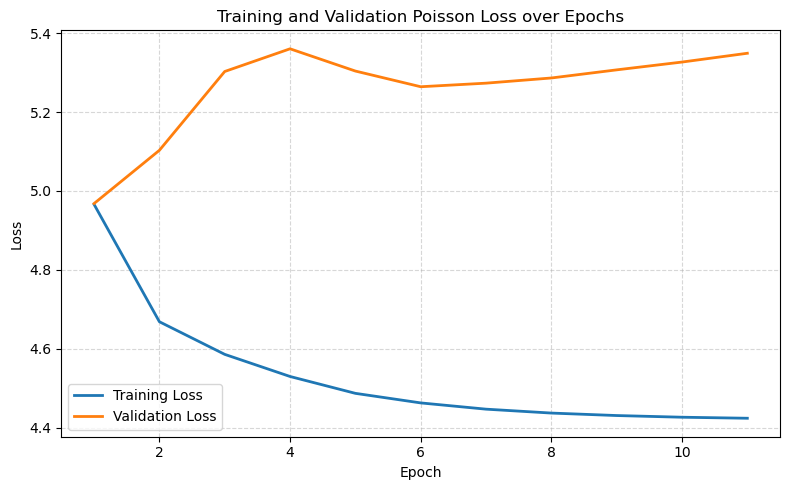

In [29]:
plot_training_history(training_history)


# 8. Most Exciting Input

In [30]:
# init_std = 0.1
# idx = 50
# l2_lambda = 1e-3

# image = (torch.randn(image_shape, device=device) * init_std).requires_grad_(True)

# l2_reg = l2_lambda * (image ** 2).mean()

# pred = model(image)[0, 0, idx]
# loss = -pred
# res = loss + l2_reg

# res.backward()

loss:  tensor(-4.6484, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-4.6650, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-4.6921, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-4.7522, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-4.8524, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-4.9883, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-5.1559, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-5.3538, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-5.5897, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-5.8564, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-6.1481, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-6.4791, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-6.8668, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-7.3092, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-7.7929, device='mps:0', grad_fn=<AddBackward0>)
loss:  tensor(-8.3122, device='mps:0', grad_fn=<AddBack

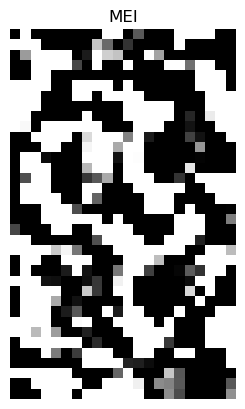

In [31]:
from neuropixel_predictor.mei.generate import generate_mei, plot_mei

device = 'mps'
neuron_idx = 0
image_shape = (1, 1, IMAGE_WIDTH, IMAGE_HEIGHT)

mei = generate_mei(
    model,
    neuron_idx,
    image_shape,
    steps=500,
    mode="cei",     # or "vei_plus", "vei_minus"
    device=device,
)

plot_mei(mei)